<a href="https://colab.research.google.com/github/kevinroccapriore/STEM-notebooks/blob/main/Cube_detector_for_EELS_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Started April 20, 2020

Here, we will aim to explore the predictability and discoverability of specific plasmon behaviors in the nanoparticles assemblies. Ideologically, it will be somewhat similar to the GP work with Chris, but will go much further since we have full access to structure and properties. Below, I will enumerate specific workflow steps, and once we get there we can hack on the GP and DNN/BNN parts (at that point, project may branch).

<font size = 7>`Puzzle Cube of Doom`</font>

1. Import all the libraries necessary to work with the EELS data. Similar to the EELS notebooks.

In [ ]:
#@title Import modules
from tqdm import tqdm_notebook
from tqdm import tqdm
from pylab import cm
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import glob
import os
import string
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import json
from pylab import cm
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy import ndimage
from scipy import signal
import operator
from skimage.filters import sobel
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from google.colab.patches import cv2_imshow
from PIL import Image
import imutils
from skimage.transform import resize

# Machine learning modules
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

from skimage.draw import polygon2mask
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle
from skimage import feature
from skimage.measure import profile_line
# from skimage.feature import blob_log

# <UNUSED> Interactivity modules <UNUSED>
# import chart_studio.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

In [ ]:
#@title Define functions

# For batch processing of hyperspectral datasets, use the following function
def bkgd_removal_all(r1a, r1b, r2a, r2b, E, SI, XY):
  NBCalc=np.asarray([[RemoveBackgroundSI2R(E,s,r1a,r1b,r2a,r2b) for s in row] for row in SI])
  SINB=NBCalc[:,:,1,:]
  ENB=NBCalc[0,0,0,:]
  SINBflat=SINB.reshape((np.prod(XY),SINB.shape[2]))
  return ENB, SINB, SINBflat
  
def organize_data(filename, plot = False):
  SIraw, XY, disp, SIraw_flat = OrganizeInput(filename) 
  SInc = CorrectNeg(SIraw, Blur = 20, Neg = -20, Pixrange = 200, plot = plot)
  SIncflat = SInc.reshape((np.prod(XY),SInc.shape[2]))
  EnergyAxes=CalibrateEnergyAxis(SInc,disp)                  # align ZLP & use dispersion to go from pixel -> eV
  Eaxflat=EnergyAxes.reshape((np.prod(XY),SInc.shape[2]))    # flatten
  E,SI=CalibrateSI(EnergyAxes,SInc, N = 5000)                # calibrate energies by making all pixels start and end at same energy values
  SIflat=SI.reshape((np.prod(XY),SI.shape[2]))  
  return E, SI, XY, SIflat

def truncate_spectrum(ENB, cutoffenergy):
  truncate = (np.abs(ENB-cutoffenergy)).argmin()
  return truncate 

def TruncateColormap(cmap = 'jet', lowerlim = 0, upperlim = 1, N=100):
    '''Cuts the upper/lower bound limits of a previously specified color map. 
    For example, user wishes to display half the jet cmap- from red to green,
    instead of from red to blue. 
    Inputs: 
        cmap: the color map to truncate
        lowerlim and upperlim: from scale from 0 to 1. lowerlim=0 and upperlim=1
        would return the identical cmap
        N number of steps
    '''
    gotcmap = plt.get_cmap(cmap)
    truncatedcolormap = LinearSegmentedColormap.from_list('list', gotcmap(np.linspace(lowerlim, upperlim, 100)),N=100)
    return truncatedcolormap

def OrganizeInput(numpy):
    SIraw = np.load(numpy)
    XY = SIraw.shape[:2]
    SIj = json.load(open(numpy[:-3]+'json','r'))
    disp = SIj['spatial_calibrations'][2]['scale']
    SIraw_flat=SIraw.reshape((np.prod(XY),SIraw.shape[2]))
    return SIraw, XY, disp, SIraw_flat
    
def LoadADF(filename):
    ADF1    = np.load(filename)
    ADF1j = json.load(open(filename[:-3]+'json','r'))
    ADF1_scale = ADF1j['spatial_calibrations'][0]['scale']
    return ADF1, ADF1_scale

def BlurSpectra_single(SIraw, sigma = 10):
    SIraw_blur_single = ndimage.filters.gaussian_filter(SIraw, sigma = sigma)
    return SIraw_blur_single

def BlurSpectra(SIraw, sigma = 10):
    SIraw_blur = np.zeros((SIraw.shape[0],SIraw.shape[1],SIraw.shape[2]))
    for i in range(SIraw.shape[0]):
        for j in range(SIraw.shape[1]):
            SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = sigma)
    return SIraw_blur

def BlurSpectra_flat(SI, sigma = 10):
    SI_blur = np.zeros_like(SI)
    for ii in range(SI_blur.shape[0]):
        SI_blur[ii] = ndimage.filters.gaussian_filter(SI[i,:], sigma = sigma)
    return SI_blur

def CorrectNeg(SIraw, Blur = 10, Neg = -20, Pixrange = 250, plot = True):
    """
    Args:
       SI = Accepts any 3-dim SI as the operated-on SI, normally raw
       Blur =   gaussian blur sigma value. Should be set 10-30
                range to avoid false peaks due to noise
       Neg =    value which is considered to be negative. 
                Generally shouldn't be set to exactly 0 (or very close,
                like -1), due to noise effects
                **this also prevents spectra which are not negative at
                all from being artificially offset**
       Pixrange = number of pixels to average (centered around most 
                negative pixel located after blurring) over for sub-
                tracting from raw data
    Returns:
       - Original SI with offset
       - Blurred SI with offset
       - Plot of original + blurred offset 
    """  
    # blurs each pixels' spectrum
    SIraw_blur = np.zeros((SIraw.shape[0],SIraw.shape[1],SIraw.shape[2]))
    for i in range(SIraw.shape[0]):
        for j in range(SIraw.shape[1]):
            SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = Blur)
    
    # local min peak search:
    # performs scipy findpeaks function (inverts signal to find MIN), then picks out most negative
    # again, should be OK due to the blurring previously
    # Derp, I think this could've been done much easier with np.min() and np.argmin()...
    # Actually maybe not, because I set a height parameter with findpeaks.
    
    MN = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    posmaxpixel = np.zeros((SIraw.shape[0],SIraw.shape[1]))     
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.amax(SIraw[i,j])<5000:
                MN[i,j] = np.nan
            else:
                posmaxpixel[i,j]= np.argmax(SIraw_blur[i,j,:])
        
                peaks,props = signal.find_peaks(-1*SIraw_blur[i,j,int(posmaxpixel[i,j]):],height = -20)
                keys = peaks.tolist()
                values = props['peak_heights'].tolist()
                peakdict = dict(zip(keys, values))     
                sorted_peakdict = sorted(peakdict.items(), key=operator.itemgetter(1))
                mostneg = np.array(sorted_peakdict[-1:])
                mostnegT = mostneg.T
                try:
                    MN[i,j] = posmaxpixel[i,j]+mostnegT[0][0] # this is the most negative pixel, value that we need   
                except IndexError:
                    MN[i,j] = np.nan # if sample TOO THICK, spectrum is noise, so will produce index error; 
                                     # this just gives that the bird by setting to NaN.

      
            
    SInc =  np.zeros_like(SIraw)      
    SInegmean = np.zeros((SIraw.shape[0],SIraw.shape[1]))        
    for i in range(SIraw_blur.shape[0]):
         for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:     # handling if sample too thick
                SInc[i,j] = SIraw[i,j]
            elif np.isnan(MN[i,j]) == False:
                SInegmean[i,j] = np.mean(SIraw_blur[i,j,int(MN[i,j]-Pixrange/2):int(MN[i,j]+Pixrange/2)])
                SInc[i,j] = SIraw[i,j] - SInegmean[i,j]
            
                
            
    # for plotting (finding scatter XY coordinates)
    x_pos, y_pos = np.zeros_like(MN), np.zeros_like(MN)
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:
                x_pos[i,j] = 0
                y_pos[i,j] = 0
            else:
                x_pos[i,j] = int(MN[i,j])
                y_pos[i,j] = SIraw_blur[i,j,int(x_pos[i,j])]
    
    i,j = np.random.randint(SIraw.shape[0]), np.random.randint(SIraw.shape[1])
    # Plotting option to show the offset performed. 
    # Set to True for single datasets, but for multiple datasets at once, usually 
    # better to set to false (in the argument itself, that is)
    if plot == True:

      fig = plt.figure(figsize=(16,4))
      gs = gridspec.GridSpec(1,2)
      ax1 = plt.subplot(gs[0,0])
      ax2 = plt.subplot(gs[0,1])
      
      ax1.plot(SIraw_blur[i,j,:])
      ax1.plot(SIraw[i,j], alpha = 0.5)
      ax1.set_ylim(-100,1000)
      ax1.axhline(0,color='k',ls='--',lw=1.5)
      
      if x_pos[i,j] == 0:
          ax1.annotate('No offset performed: \nCould not find negative enough value', xy = (0.5,0.7), xycoords = 'axes fraction')
      else:
          ax1.scatter(x_pos[i,j], y_pos[i,j], color = 'r')
          patch1 = patches.Rectangle((x_pos[i,j]-Pixrange/2, y_pos[i,j]-30), Pixrange, 60, linewidth = 1, edgecolor = 'red', facecolor = 'red', fill = False)
          ax1.add_patch(patch1)
    
    
      ax2.plot(SInc[i,j])
      ax2.set_ylim(-100,1000)
      ax2.axhline(0,color='k',ls='--',lw=1.5);
      
      # r'$\bf{fixed \ data}$
      
      ax1.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Raw SI, blurred SI, region of averaging'.format(i,j))
      ax2.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Corrected SI'.format(i,j))
    
    return SInc

def CalibrateEnergyAxis(SI,disp,style='fwhm',subfitwidth=8):
    Einit=np.arange(0,SI.shape[2])*disp
    if style=='pixel': ZLPC=np.array([[Einit[np.argmax(s)] for s in row] for row in SI])
    if style=='fwhm':
        lh,uh=[],[]
        avspec=np.average(SI,axis=(0,1))
        for row in SI:
            lh.append([]);uh.append([])
            for s in row:
                if np.amax(s)<1000: # This line is for thick samples when ZLP drops to noise levels
                    s=avspec
                lh[-1].append(Einit[np.argmin(np.abs(s[:np.argmax(s)]/np.amax(s)-0.5))])
                uh[-1].append(Einit[np.argmin(np.abs(s[np.argmax(s):]/np.amax(s)-0.5))+np.argmax(s)])
        lh=np.asarray(lh)        
        uh=np.asarray(uh)
        ZLPC=np.average([uh,lh],axis=0)
    if style=='subpixel':
        def gauss(x,a,x0,s): return a*np.exp(-(x-x0)**2/s**2)
        from scipy.optimize import curve_fit
        ZLPC=np.array([[curve_fit(gauss,Einit[np.argmax(s)-W:np.argmax(s)+W],
                               s[np.argmax(s)-W:np.argmax(s)+W]/np.amax(s))[0][1] for s in row] for row in SI])
    return np.array([[Einit-c for c in row] for row in ZLPC])
    
def CalibrateSI(EAx,SI,N=5000):
    m,M = np.amax(np.amin(EAx,axis=(2))), np.amin(np.amax(EAx,axis=(2)))
    Eout=np.linspace(m,M,N)[1:]
    Eout=np.linspace(m,M,N,endpoint=True)
    SIout=np.array([[interpolate.interp1d(e,s)(Eout) for e,s in zip(erow,srow)] for erow,srow in zip(EAx,SI)])
    return Eout,SIout
  
def FitPowerlaw(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    #e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,3))
    
    ax=fig.add_subplot(131)
    
    plt.plot(E,S,color='k',label='Data')
    plt.plot(E[ist:ien],S[ist:ien],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=13)
    fite=np.linspace(E[ist+1],E[ien-1],1000)
    f=interpolate.interp1d(E[ist:ien],S[ist:ien],kind='linear')
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    plt.ylim(0,0.002)
    r,A0=np.polyfit(elog,slog,1)
    
    ax=fig.add_subplot(132)
    
    plt.plot(E[ist:],S[ist:],color='k',label='Data')
    plt.plot(E[ist:],np.exp(A0)*E[ist:]**(r),'b',lw=3,label='Power Law Fit')
    plt.tick_params(labelsize=16)
    plt.legend(frameon=False,fontsize=13)
    
    ax=fig.add_subplot(133)
    
    plt.axhline(0,color='k')
    plt.plot(E[ist:],S[ist:]-np.exp(A0)*E[ist:]**(r),color='b',label='Powerlaw Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    plt.subplots_adjust(top=1,bottom=0.06,right=1,left=0.15)
    plt.legend(frameon=False,fontsize=10,labelspacing=0.3,handlelength=1,handletextpad=0.2)
    plt.ylim(-0.0001,0.001)
    return fite,0.#,f(fite)-np.exp(a*fite**3+b*fite**2+c*fite+d)
  
def FitPowerlaw2R(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,3))
    
    ax=fig.add_subplot(131)
    
    plt.plot(E*1000,S,color='k',label='Data')
    plt.plot(e*1000,s,marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=13)
    fite=np.linspace(E[is1+1],E[ie2-1],300)
    f=interpolate.interp1d(E[is1:ie2],S[is1:ie2],kind='linear')
    nozeros=s[np.where(s>0)]
    nozeroe=e[np.where(s>0)]
    elog=np.log(nozeroe)
    slog=np.log(nozeros)
    plt.ylim(0,0.02)
    r,A0=np.polyfit(elog,slog,1)
    
    ax=fig.add_subplot(132)
    
    plt.plot(E[is1:]*1000,S[is1:],color='k',label='Data')
    plt.plot(E[is1:]*1000,np.exp(A0)*E[is1:]**(r),'b',label='Power Law Fit')
    plt.tick_params(labelsize=16)
    plt.legend(frameon=False,fontsize=13)
    
    ax=fig.add_subplot(133)
    
   # plt.plot(fite,f(fite)-np.exp(a*fite**3+b*fite**2+c*fite+d),color='r',label='Exponential Subtraction')
    plt.plot(E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r),color='b',label='Powerlaw Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    plt.subplots_adjust(top=1,bottom=0.06,right=1,left=0.15)
    plt.axhline(0,color='k')
    plt.legend(frameon=False,fontsize=10,labelspacing=0.3,handlelength=1,handletextpad=0.2)
    
    plt.ylim(-0.0001,0.001)
    
    return E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r)


## background subtraction using either 1 region or 2 regions:

def RemoveBackgroundSI(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    f=interpolate.interp1d(E[ist:ien],S[ist:ien],kind='linear')
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    if len(np.where(S[ist:ien]>0)[0]) == 0.: 
        plt.plot(E[ist:],S[ist:])
        return E[ist:],np.zeros(E[ist:].shape)
    r,A0=np.polyfit(elog,slog,1)
    return E[ist:],S[ist:]-np.exp(A0)*E[ist:]**(r),
  
def RemoveBackgroundSI2R(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    elog=np.log(e[np.where(s>0)])
    slog=np.log(s[np.where(s>0)])
    r,A0=np.polyfit(elog,slog,1)
    return E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r)

def Perform_PCA(SINB, SINBflat, ENB, SI, nc = 6):
    ZLPmap = np.mean(SI[:,:,:],axis=2)
    truncate = truncate_spectrum(ENB, cutoffenergy = 0.2)

    cmap = 'magma'
    colors=['DarkOrange','BlueViolet','DodgerBlue','Crimson','MediumSeaGreen','Tan','HotPink','Yellow','Black']
    clf = PCA(n_components=nc)
    X_vec_t = clf.fit_transform(SINBflat[:,truncate:])
    components = clf.components_
    w, h, n = SINB.shape
    X_vec_t = X_vec_t.reshape(w, h, nc)
    rows = int(np.ceil(float(nc)/3))
    cols = int(np.ceil(float(nc)/rows))
    
    print("{}".format(filelist[ii]))
    plt.figure(figsize=(6,0.6))
    plt.title('\nDataset {}'.format(ii+1), fontsize = 20, loc = 'left')
    plt.axis('off')
    fig0,ax0 = plt.subplots(figsize = (5,5))
    ax0.imshow(ZLPmap, cmap = 'gray_r')
    ax0.axis('off')
    plt.tight_layout()

    fig1,ax1 = plt.subplots(figsize = (11,5))
    for i in range(nc):
        ax1.plot(ENB[truncate:],components[i], color = colors[i], label = i+1)
        ax1.grid(True)
        ax1.set_xlabel("Energy loss (eV)", fontsize = 14)
        ax1.set_ylabel("Relative strength (arb)", fontsize = 14)
        ax1.tick_params(labelsize=14)
        ax1.legend()
        ax1.set_title('PCA spectral components', fontsize = 16)
        plt.tight_layout()
    plt.show()
    print("\n\n")

    gs2 = gridspec.GridSpec(rows, cols)
    fig2 = plt.figure(figsize = (4*cols, 3*(1+rows//1)))   
    for i in range(nc):
        ax2 = fig2.add_subplot(gs2[i])
        ax2.imshow(X_vec_t[:, : ,i],cmap = cmap)
        ax2.text(0.45*X_vec_t[:, : ,i].shape[1], -0.05*X_vec_t[:, : ,i].shape[0], "Component", ha="center", va="bottom", fontsize=16,color="k")
        # ax2.text(0.67*X_vec_t[:, : ,i].shape[1], -0.05*X_vec_t[:, : ,i].shape[0], r"$\bf{}$".format(i+1), ha="center", va="bottom", fontsize=16, color=colors[i])
        ax2.text(0.58*X_vec_t[:, : ,i].shape[1] + 12, -0.05*X_vec_t[:, : ,i].shape[0], r"$\bf{}$".format(i+1), ha="center", va="bottom", fontsize=16, color=colors[i])
        plt.setp([ax2],xticks=[], yticks=[])
        plt.tight_layout()
    plt.show()
    print("\n_______________________________________________________________________________________________________")
    print("\n\n\n\n")

def Perform_NMF_null(SINBflat, ENB, SI, XY, N = 6):
  truncate = truncate_spectrum(ENB_list[ii], cutoffenergy = 0.2)
  # negativity handle #
  SIdecon=np.copy(SINBflat[:,truncate:])
  SIdecon[np.where(SIdecon<0)]=0
  # # # # # # # # # # # 
  model=NMF(n_components=N)
  NMFIm=model.fit_transform(SIdecon[:,:])
  NMFSpec=model.components_
  NMFIm=NMFIm.reshape(XY+(N,)).transpose(2,0,1)
  ZLPmap = np.mean(SI[:,:,:],axis=2)

  cmap = 'magma'
  colors=['DarkOrange','BlueViolet','DodgerBlue','Crimson','MediumSeaGreen','Tan','HotPink','Yellow','Black']
  rows = int(np.ceil(float(N)/3))
  cols = int(np.ceil(float(N)/rows))

  print("{}".format(filelist[ii]))
  plt.figure(figsize=(6,0.6))
  plt.title('\nDataset {}'.format(ii+1), fontsize = 20, loc = 'left')
  plt.axis('off')
  fig0,ax0 = plt.subplots(figsize = (5,5))
  ax0.imshow(ZLPmap, cmap = 'gray_r')
  ax0.axis('off')
  plt.tight_layout()

  fig1,ax1 = plt.subplots(figsize = (11,5))
  for i in range(N):
      ax1.plot(ENB[truncate:],NMFSpec[i], color = colors[i], label = i+1)
      ax1.grid(True)
      ax1.set_xlabel("Energy loss (eV)", fontsize = 14)
      ax1.set_ylabel("Relative strength (arb)", fontsize = 14)
      ax1.tick_params(labelsize=14)
      ax1.legend()
      ax1.set_title('NMF spectral components', fontsize = 16)
      plt.tight_layout()
  plt.show()
  print("\n\n")

  gs2 = gridspec.GridSpec(rows, cols)
  fig2 = plt.figure(figsize = (4*cols, 3*(1+rows//1)))   
  for i in range(nc):
      ax2 = fig2.add_subplot(gs2[i])
      ax2.imshow(NMFIm[i, : , :],cmap = cmap)
      ax2.text(0.45*NMFIm[i, : ,:].shape[1], -0.05*NMFIm[i, : ,:].shape[0], "Component", ha="center", va="bottom", fontsize=16,color="k")
      # ax2.text(0.67*NMFIm[i, : ,:].shape[1], -0.05*NMFIm[i, : ,:].shape[0], r"$\bf{}$".format(i+1), ha="center", va="bottom", fontsize=16, color=colors[i])
      ax2.text(0.58*NMFIm[i, : ,:].shape[1] + 12, -0.05*NMFIm[i, : ,:].shape[0], r"$\bf{}$".format(i+1), ha="center", va="bottom", fontsize=16, color=colors[i])

      plt.setp([ax2],xticks=[], yticks=[])
      plt.tight_layout()
  plt.show()
  print("\n________________________________________________________________________________________")
  print("\n\n\n\n")

def Perform_NMF_offset(SINBflat, ENB, SI, XY, N = 6):
  truncate = truncate_spectrum(ENB_list[ii], cutoffenergy = 0.2)

  # negativity handle #
  SIdecon_=np.copy(SINBflat[:,truncate:])
  SIdecon = np.zeros_like(SIdecon_)
  for jj in range(SIdecon_.shape[0]):
    minval = np.min(SIdecon_[jj])
    if minval < 0:
      SIdecon[jj, :] = SIdecon_[jj, :] - minval
    else:
      SIdecon[jj, :] = SIdecon_[jj, :]
  # # # # # # # # # # # 
  model=NMF(n_components=N)
  NMFIm=model.fit_transform(SIdecon[:,:])
  NMFSpec=model.components_
  NMFIm=NMFIm.reshape(XY+(N,)).transpose(2,0,1)
  ZLPmap = np.mean(SI[:,:,:],axis=2)

  cmap = 'magma'
  colors=['DarkOrange','BlueViolet','DodgerBlue','Crimson','MediumSeaGreen','Tan','HotPink','Yellow','Black']
  rows = int(np.ceil(float(N)/3))
  cols = int(np.ceil(float(N)/rows))

  print("{}".format(filelist[ii]))
  plt.figure(figsize=(6,0.6))
  plt.title('\nDataset {}'.format(ii+1), fontsize = 20, loc = 'left')
  plt.axis('off')
  fig0,ax0 = plt.subplots(figsize = (5,5))
  ax0.imshow(ZLPmap, cmap = 'gray_r')
  ax0.axis('off')
  plt.tight_layout()

  fig1,ax1 = plt.subplots(figsize = (11,5))
  for i in range(N):
      ax1.plot(ENB[truncate:],NMFSpec[i], color = colors[i], label = i+1)
      ax1.grid(True)
      ax1.set_xlabel("Energy loss (eV)", fontsize = 14)
      ax1.set_ylabel("Relative strength (arb)", fontsize = 14)
      ax1.tick_params(labelsize=14)
      ax1.legend()
      ax1.set_title('NMF spectral components', fontsize = 16)
      plt.tight_layout()
  plt.show()
  print("\n\n")

  gs2 = gridspec.GridSpec(rows, cols)
  fig2 = plt.figure(figsize = (4*cols, 3*(1+rows//1)))   
  for i in range(nc):
      ax2 = fig2.add_subplot(gs2[i])
      ax2.imshow(NMFIm[i, : , :],cmap = cmap)
      ax2.text(0.45*NMFIm[i, : ,:].shape[1], -0.05*NMFIm[i, : ,:].shape[0], "Component", ha="center", va="bottom", fontsize=16,color="k")
      # ax2.text(0.67*NMFIm[i, : ,:].shape[1], -0.05*NMFIm[i, : ,:].shape[0], r"$\bf{}$".format(i+1), ha="center", va="bottom", fontsize=16, color=colors[i])
      ax2.text(0.58*NMFIm[i, : ,:].shape[1] + 12, -0.05*NMFIm[i, : ,:].shape[0], r"$\bf{}$".format(i+1), ha="center", va="bottom", fontsize=16, color=colors[i])

      plt.setp([ax2],xticks=[], yticks=[])
      plt.tight_layout()
  plt.show()
  print("\n________________________________________________________________________________________")
  print("\n\n\n\n")

##################################
##### Cube finding functions #####
##################################

def find_particles(ZLPimage, upscale = 5, blur = 3, binarythresh = 0.1, 
                 min_thresh = 0.02, max_thresh = 0.2, plot = True):
  """
  Finds particle centers in a given a grayscale image.
  Does so by performing a series of filters (gaussian blur, sobel, binary thresholding)
  to the input image, and finding particle contours with OpenCV2, and finally 
  calculating the moment (i.e., particle center) of each contour.
  Parameters
  ----------
  ZLPimage : 2D image obtained by integrating spectrum image in the zero loss peak
      spectral region (or, more easily, integrating the entire spectral range
      because it is dominated by ZLP anyway)
  upscale : Factor with which to increase the input image size. E.g., if original image
      has shape (128,128), if upscale is 2, then new image will have shape (256, 256)
  blur : Kernel for sigma in gaussian blur function. Use this to smooth out internal
      particle fluctations in intensity
  binarythresh : Threshold parameter on a [0,1] scale. Performed after upscaling and blur
  min_thresh : minimum area to consider in contours 
      (small min_thresh allows smaller contours)
  max_thresh : maximum area to consider in contours 
      (small max_thresh avoids contours around groups of particles) 
  plot : True or False. Highly recommended to keep True. Shows performance of particle finding    
  """
  # Step 1. Threshold the image so that all particles are separated! IMPORTANT!!!

  # Take log to smooth out intensities in particles
  ZLPimage_ = np.log(ZLPimage)
  # Normalize and invert scale
  ZLP_norm = ((1/ZLPimage_) - np.min(1/ZLPimage_))/(np.ptp(1/ZLPimage_))
  # artificially upscale image for better processing, for contours and corners later
  scale = upscale 
  ZLP_upscale = resize(ZLP_norm, (ZLP_norm.shape[0]*scale, ZLP_norm.shape[1]*scale))
  ZLP_blurred = gaussian_filter(ZLP_upscale, sigma = blur)
  threshold = binarythresh
  filter_sobel_ = sobel(ZLP_blurred)
  # Normalize the filtered image [0,1]
  filter_sobel = (filter_sobel_ - np.min(filter_sobel_))/np.ptp(filter_sobel_)
  mask = np.copy(filter_sobel)
  mask[np.where(filter_sobel<threshold)] = 1
  mask[np.where(filter_sobel>=threshold)] = 0
  # convert to [0,255] scale for CV2 processing
  ZLP255 = 255*(mask - np.min(mask))/np.ptp(mask).astype(int)

  LOW_THRESH = 255/2  # not needed, but cv2 seems to have different result with the binary stuff,
  # keep in middle for now
  SCALE = 1 # Already upscaled original image, not necessary again

  # Convert to cv2 format (i.e., save as jpeg and open in cv2)
  # Yikes, is this OK to do? number of pixels and locations preserved?
  im = Image.fromarray(ZLP255)
  im = im.convert("L")
  im.save("ZLP.jpeg")

  testimage = cv2.imread("ZLP.jpeg")
  # testimage2 = cv2.resize(testimage2_, (testimage2_.shape[0]*SCALE, testimage2_.shape[1]*SCALE))

  # Read as grayscale
  gray = cv2.cvtColor(testimage, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, LOW_THRESH, 255, cv2.THRESH_BINARY)[1]

  MIN_THRESH = min_thresh*testimage.shape[0]*testimage.shape[1] # Avoid small contours of irregularities within particles
  MAX_THRESH = max_thresh*testimage.shape[0]*testimage.shape[1] # Avoid large contour encompassing groups of particles

  cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, 
                          cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  Centers_x = []
  Centers_y = []
  ContourAreas_ = []
  # loop over the contours
  for c in cnts:
      if cv2.contourArea(c) > MIN_THRESH and cv2.contourArea(c) < MAX_THRESH:
        approx = cv2.approxPolyDP(c, 0.01*cv2.arcLength(c, True), True)
        # cv2.drawContours(testimage, [approx], 0, (0,255,0), 2)
        x = approx.ravel()[0]
        y = approx.ravel()[1]
          # compute the center of the contour by image moment
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        Centers_x.append(cX)
        Centers_y.append(cY)
        # draw the contour and center of the shape on the image
        cv2.circle(testimage, (cX, cY), 3, (0, 0, 255), -1)
        ContourAreas_.append(cv2.contourArea(c))

  Centers = np.array([Centers_y, Centers_x]).T

  testimage = cv2.cvtColor(testimage, cv2.COLOR_BGR2RGB)
  ContourAreas = np.array(ContourAreas_)

  # for contour in cnts:
  #   (x,y,w,h) = cv2.boundingRect(contour)
  #   cv2.rectangle(testimage, (x,y), (x+w,y+h), (0,255,0), 2)

  # # Create secondary image to draw rotated rectangles on:
  # # whole image is zero except contours

  # ZLPzeros = np.zeros_like((ZLP255))
  # im_zero = Image.fromarray(ZLPzeros)
  # im_zero = im_zero.convert("L")
  # im_zero.save("zeros.jpeg")
  # zeros = cv2.imread("zeros.jpeg")

  RectangleAngles = []
  RotRects = []
  FilteredImages = []

  for contour in cnts:
    if cv2.contourArea(contour) > MIN_THRESH and \
       cv2.contourArea(contour) < MAX_THRESH:
      rotrect = cv2.minAreaRect(contour)
      RotRects.append(rotrect[:2])


      ZLPzeros = np.zeros_like((ZLP255))
      im_zero = Image.fromarray(ZLPzeros)
      im_zero = im_zero.convert("L")
      im_zero.save("zeros.jpeg")
      zeros = cv2.imread("zeros.jpeg", cv2.IMREAD_GRAYSCALE)


      # RotRects.append(rotrect)
      box = cv2.boxPoints(rotrect)
      box = np.int0(box)
      cv2.drawContours(testimage,[box],0,(0,255,0),2)
      cv2.drawContours(zeros,[box],0,(255,255,255),2)
      RectangleAngles.append(rotrect[-1])

      Filtered_image_ = np.array(zeros)
      Filtered_image_ = (Filtered_image_ - np.min(Filtered_image_))/np.ptp(Filtered_image_)
      FilteredImages.append(Filtered_image_)
  

 # convert to numpy array
  RotRects = np.array([RotRects])[0]

  # Filtered_image_ = np.array(zeros)
  # Filtered_image_r = resize(Filtered_image_, 
  #                           (Filtered_image_.shape[0]/scale, 
  #                            Filtered_image_.shape[1]/scale)
  #                           )
  # Filtered_image0 = (Filtered_image_ - np.min(Filtered_image_))/np.ptp(Filtered_image_)
  # Filtered_image = np.copy(Filtered_image0)

  # WHY AM I DOING THIS, CANNY FILTER does FINE.... but, it doesn't know which 
  # particle it is closer to. With this, we.. still don't know, 
  # but we do have other information
  # So just do canny filter on the normalized Log ZLP:

  # Canny_filtered = feature.canny(ZLP_norm)

  for kk in range(len(RectangleAngles)):
    if RectangleAngles[kk] < -45:
      RectangleAngles[kk] = (RectangleAngles[kk] + 90)
      # If adding 90 deg, then W and H swap! Need to swap them too
      RotRects[kk] = np.roll(RotRects[kk][1],1)
    else:
      RectangleAngles[kk] = RectangleAngles[kk]

  if plot == True:
    fig,ax=plt.subplots(1,3,figsize=(18,6))
    ax[0].imshow(testimage, origin = 'lower')
    ax[1].imshow(ZLP_upscale, origin = 'lower')
    ax[1].scatter(Centers[:,1], Centers[:,0], c='r', s = 15)

    temparray = np.zeros((len(FilteredImages), FilteredImages[0].shape[0], FilteredImages[0].shape[1]))
    for k in range(len(FilteredImages)):
      temparray[k] = FilteredImages[k]*(k+1)
    ax[2].imshow(np.sum(temparray,axis=0), origin = 'lower', cmap = 'jet')
  
  # Put back into original coordinate system
  Centers = Centers/upscale
  RotRects = RotRects/upscale

  return Centers, RectangleAngles, RotRects, FilteredImages

def compute_corner_dist(corner_1, corner_2):
  dist = np.sqrt((corner_1[0] - corner_2[0])**2 + (corner_1[1] - corner_2[1])**2)
  return dist

def rotate_point(origin, point, angle):   # SINGLE POINT
  ox, oy = origin
  point = point
  x, y = point
  qx = ox + np.cos(np.deg2rad(angle)) * (x - ox) + np.sin(np.deg2rad(angle)) * (y - oy)
  qy = oy + -np.sin(np.deg2rad(angle)) * (x - ox) + np.cos(np.deg2rad(angle)) * (y - oy)
  rotated = qx,qy
  return rotated

# Need a rotation transformation to revolve around specified origin
def rotate_points(origin, points, angle):  # ARRAY OF POINTS
  ox, oy = origin
  points = points
  rotated = np.zeros((points.shape[0], points.shape[1]))
  for ii in range(points.shape[0]):
    x, y = points[ii]
    qx = ox + np.cos(np.deg2rad(angle)) * (x - ox) + np.sin(np.deg2rad(angle)) * (y - oy)
    qy = oy + -np.sin(np.deg2rad(angle)) * (x - ox) + np.cos(np.deg2rad(angle)) * (y - oy)
    rotated[ii] = qx,qy
  return rotated

def Edge_sweeper(image, startcoord, sweepthresh = 0.1, stepsize = 1, order = 3, plot = True):
  '''
  From a starting coordinate in an image, extends a vector (line profile) 
  to the edge of the image and sweeps a full revolution around the image 
  in increments given by stepsize. The first edge encountered by this vector 
  is stored as a function of angle of rotation from the startcoord.
  
  Parameters
  ----------
  image :  
      Input 2D numpy array, image format. For use with CONTOUR images 
      (simple thresholded image which are 0's everywhere except for particle
      contours which are 1's)
  startcoord : Tuple. E.g., (45,33)
      Position from which to extend all vectors that sweep a circle
  sweepthresh : Default 0.1
      Threshold value which when reached calls for a positive edge detection
  stepsize : default 1
      Number of line profiles that are evenly spaced (in angular increments)
      Set stepsize = 1 for 360 line profiles in a complete revolution
  order : default 3
      Order of spline interpolation (0 to 5 accepted) for lineprofiling 
      across pixels. Order = 0 means nearest-neighbor interpolation. 
  plot : True or False
      Whether or not to plot output of angle edge sweep. Recommend to keep on.
  
  Returns
  -------
  EDT : "edge distance theta"
      Array containing [theta, distance to edge at theta from startcoord,
      x distance to edge, y distance to edge]

  '''
  image = image # MUST BE SQUARE IMAGE! if not, MAKE square! 
                # I can add function to do this if needed.. (take largest axis and pad other to make same size)
  sweepthresh = sweepthresh
  stepsize = stepsize
  sweeprange = np.arange(0, 359, stepsize)
  EDT = np.zeros((len(sweeprange), 4))  # Final output array
    
  x0, y0 = startcoord
  end = (startcoord[0], image.shape[1]*2)  # Multiply by 2 to ensure lineprofile extends to end of image
  
  # iterate over rotated vectors

  for ii in range(len(sweeprange)):
    angle = sweeprange[ii]
    start = startcoord
    end_rot = rotate_point(start, end, angle)
    linescan = profile_line(image, start, end_rot, order = order, linewidth = 1, cval = 0)

    try:
      first = np.min(np.where(linescan>sweepthresh)) # only need the FIRST
      # print('edge detected at {}'.format(first))
      edgepoint_y = start[0] + first*np.sin(np.deg2rad(angle))
      edgepoint_x = start[1] + first*np.cos(np.deg2rad(angle))
      edgepoint = [edgepoint_x, edgepoint_y]
      edgedistance = compute_corner_dist(edgepoint, np.roll(start,1))
    except ValueError:  # it means it never encountered a boundary
      first = end_rot[1]
      # print('no edge detected')
      edgepoint_y, edgepoint_x = np.nan, np.nan
      edgepoint = [np.nan, np.nan]
      edgedistance = compute_corner_dist(edgepoint, start)

    if np.isnan(edgepoint_y):
      EDT[ii][0] = np.nan
    else:
      EDT[ii][0] = angle
    EDT[ii][1] = edgedistance
    EDT[ii][2] = edgepoint_x
    EDT[ii][3] = edgepoint_y
                  
  if plot == True:

    plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(1,2)
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.imshow(image, origin='lower')
    for ii in range(len(sweeprange)):
      ax1.plot([startloc[1], EDT[ii,2]], [startloc[0], EDT[ii,3]], c='r', alpha = 0.5)
    ax1.scatter(startloc[1], startloc[0], c='yellow')
    ax2.plot(EDT[:,0], EDT[:,1])
    ax2.set_xlabel(r'$\theta$', fontsize = 24)
    ax2.set_ylabel('Distance to detectable edge (pixels)', fontsize = 16, labelpad = 15)
    ax2.tick_params(labelsize = 14, size = 8)
    ax2.set_title('Edge detection from start coordinate: ' + r'$\bf({},{})$'.format(x0,y0), fontsize = 16);
    
  return EDT

def particle_mask(Cube_Y, image):
  temp1 = Cube_Y[2:,:2][np.argsort(Cube_Y[2:,1])]
  # mask by polygon to remove the first cube from the image
  # Requires precise ORDERING of the coordinates! Next few lines do this.
  polygoncoords = Cube_Y[:2,:2]
  temp1 = Cube_Y[2:,:2][np.argsort(Cube_Y[2:,1])]   # ascending order
  temp2 = Cube_Y[2:,:2][np.argsort(-Cube_Y[2:,1])]  # descending order

  if (polygoncoords[1,1] - polygoncoords[0,1]) < 0: # It means moving LEFTwards; otherwise, right
    polygoncoords = np.concatenate((polygoncoords, temp1))
  else:
    polygoncoords = np.concatenate((polygoncoords, temp2))

  # generate polygon mask
  mask_ = polygon2mask(image.shape, polygoncoords) # Generate mask from polygon coordinates
  mask = np.copy(mask_).astype(int)  # Convert boolean to int so we can invert

  # Invert the mask (can't do 1/mask because of divide by zero. So do some juggling)
  mask[np.where(mask==0)]=2 # store zeros as arbitrary temp value
  mask[np.where(mask==1)]=0
  mask[np.where(mask==2)]=1

  return mask

def find_next(ZLP_n, power, mask, threshold):

  img = (ZLP_n*mask)**power  
  img_ = gaussian_filter(img, sigma = 1)
  img_ = (img_ - np.min(img_))/(np.ptp(img_))
  img_t = np.copy(img_)
  thresh = threshold
  img_t[np.where(img_t<thresh)] = 0
  img_t[np.where(img_t>=thresh)] = 1
  # img_ = sobel(img_)

  coords = corner_peaks(corner_harris(img_), min_distance=5, threshold_rel = 0.005)
  Corners_ = corner_subpix(img_t, coords, window_size=15, alpha = 0.5)

  # If subpixel precision fails, it goes to unclassified NaN. If this happens, we don't want it,
  # so revert back to other position to we at least have something
  # Also, sort based on distance to (0,0) reference point
  cornerdistances_temp = np.zeros((len(Corners_)))
  for ii in range(len(Corners_)):
    if np.isnan(Corners_[ii,0]):
      Corners_[ii,0], Corners_[ii,1] = coords[ii,0], coords[ii,1]
    cornerdistances_temp[ii] = compute_corner_dist([0,0], Corners_[ii])
    # Sort the Corners based on their distances to (0,0)
  Corners = Corners_[cornerdistances_temp.argsort()]

  cornerdistances_ = np.zeros((len(Corners)-1))
  for ii in range(len(Corners)-1):
    cornerdistances_[ii] = compute_corner_dist(Corners[0], Corners[ii+1])

  # Add zero to the beginning of the array so that it matches in shape to corners array (zero distance to itself)
  cornerdistances = np.roll(np.append(cornerdistances_, 0), 1)
  cornerdistances = np.reshape(cornerdistances, (cornerdistances.shape[0], 1))

  Corners_new_ = np.copy(Corners)
  Corners_new = np.concatenate((Corners_new_, cornerdistances), axis = 1)

  Corners_new_sort = Corners_new[Corners_new[:,2].argsort()]
  Cube_ = Corners_new_sort[1:4]

  temp_ = np.concatenate((Corners[0], [0]), axis = 0)
  temp = np.reshape(temp_, (1,3)) # Reshape so concatenate wont throw error
  Cube = np.concatenate((temp, Cube_))

  return Cube

def find_first(ZLP_n, threshold, power, sigma):
  threshold = threshold
  img = ZLP_n**1
  # img_ = gaussian_filter(img, sigma = sigma)
  img_ = (img - np.min(img))/(np.ptp(img))
  img_t = np.copy(img_)
  img_t[np.where(img_t<threshold)] = 0
  img_t[np.where(img_t>=threshold)] = 1
  # img_ = sobel(img_)

  coords = corner_peaks(corner_harris(img_), min_distance=5, threshold_rel = 0.01)
  Corners_ = corner_subpix(img_t, coords, window_size=15, alpha=0.5)
  # coords = corner_peaks(corner_harris(ZLP_n), min_distance=5, threshold_rel = 0.01)
  # Corners_ = corner_subpix(ZLP_n, coords, window_size=15, alpha=0.5)

  cornerdistances_temp = np.zeros((len(Corners_)))
  # If subpixel precision fails, it goes to unclassified NaN. If it happens, we don't want it, \
  # so revert back to other position to we at least have something
  # Also, compute distances of each corner to origin = (0,0)
  for ii in range(len(Corners_)):
    if np.isnan(Corners_[ii,0]):
      Corners_[ii,0], Corners_[ii,1] = coords[ii,0], coords[ii,1]
    cornerdistances_temp[ii] = compute_corner_dist([0,0], Corners_[ii])
    
  # Sort the Corners based on their distances to (0,0)
  Corners = Corners_[cornerdistances_temp.argsort()]

  # For the first corner:
  # from Corners, select the corner closest to zero (found just before)

  cornerdistances_ = np.zeros((len(Corners)-1))
  for ii in range(len(Corners)-1):
    cornerdistances_[ii] = compute_corner_dist(Corners[0], Corners[ii+1])
  cornerdistances = np.roll(np.append(cornerdistances_, 0), 1)
  cornerdistances = np.reshape(cornerdistances, (cornerdistances.shape[0], 1))

  Corners_new = np.copy(Corners)
  Corners_new = np.concatenate((Corners_new, cornerdistances), axis = 1)

  Corners_new_sort = Corners_new[Corners_new[:,2].argsort()]
  Cube_ = Corners_new_sort[1:4]

  temp_ = np.concatenate((Corners[0], [0]), axis = 0)
  temp = np.reshape(temp_, (1,3)) # Reshape so concatenate wont throw error
  Cube = np.concatenate((temp, Cube_))

  return Cube

def find_center_and_angle(Cubearray):
  opposite0 = Cubearray[np.argmax(Cubearray.T[2])][:2]
  if np.argmax(Cubearray.T[2]) == 1:
    opposite1a = Cubearray[2][:2]
    opposite1b = Cubearray[3][:2]
  elif np.argmax(Cubearray.T[2]) == 2:
    opposite1a = Cubearray[1][:2]
    opposite1b = Cubearray[3][:2]
  elif np.argmax(Cubearray.T[2]) == 3:
    opposite1a = Cubearray[1][:2]
    opposite1b = Cubearray[2][:2]
  #############################
    # Finding centers again #
  #############################
  diff1 = (Cubearray[0,:2] - opposite0)/2
  diff2 = (opposite1a - opposite1b)/2

  ### Assign the SIGN ###
  ###########################################
  # Corner pair 1
  if diff1[1] > 0:  # tells us which corner is to the left/right
    xsign1 = -1
  else:
    xsign1 = 1

  if diff1[0] > 0:
    ysign1 = -1
  else:
    ysign1 = 1

  # Corner pair 2
  if diff2[1] > 0:  # tells us which corner is to the left/right
    xsign2 = -1
  else:
    xsign2 = 1

  if diff2[0] > 0:
    ysign2 = -1
  else:
    ysign2 = 1
  ##########################################

  # Apply the sign
  cornerdelx1 = xsign1*np.abs(diff1[1])
  cornerdely1 = ysign1*np.abs(diff1[0])

  cornerdelx2 = xsign2*np.abs(diff2[1])
  cornerdely2 = ysign2*np.abs(diff2[0])

  # Calculate the proper center
  center1 = [Cubearray[0,1] + cornerdelx1, Cubearray[0,0] + cornerdely1]
  center2 = [opposite1a[1] + cornerdelx2, opposite1a[0] + cornerdely2]
  center_avg = [np.mean([center1[0], center2[0]]), np.mean([center1[1], center2[1]])]

  # Y sort all four corners
  temp_ = Cubearray[:,0]                           # select only the Y coordinates
  temp = np.reshape(temp_, (temp_.shape[0]))       # reshape so sorting can be done
  Cube_Y = Cubearray[temp.argsort()] 

  Cube_Y_low = Cube_Y[:2]
  Cube_Y_high = Cube_Y[2:]

  # X sort the lowest two Y's:
  temp = Cube_Y_low[:,1]                           # select only the X coordinates
  LL = Cube_Y_low[temp.argsort()][0]
  LR = Cube_Y_low[temp.argsort()][1]

  # X sort the highest two Y's:
  temp = Cube_Y_high[:,1]                           # select only the X coordinates
  UL = Cube_Y_high[temp.argsort()][0]
  UR = Cube_Y_high[temp.argsort()][1]

  # Now measure the angle from the center to each of these corners.
  # Because we know which quadrant each corner is in,
  # we can measure that angle relative to a defined horizontal or vertical

  # LL
  x,y = np.abs(center_avg[0] - LL[1]), np.abs(center_avg[1] - LL[0])
  theta1 = np.rad2deg(np.arctan2(y,x)) - 45
  # LR
  x,y = np.abs(center_avg[0] - LR[1]), np.abs(center_avg[1] - LR[0])
  theta2 = 90-np.rad2deg(np.arctan2(y,x)) - 45
  # UL
  x,y = np.abs(center_avg[0] - UL[1]), np.abs(center_avg[1] - UL[0])
  theta3 = 90-np.rad2deg(np.arctan2(y,x)) - 45
  # UR
  x,y = np.abs(center_avg[0] - UR[1]), np.abs(center_avg[1] - UR[0])
  theta4 = np.rad2deg(np.arctan2(y,x)) - 45

  theta_list = [theta1, theta2, theta3, theta4]
  theta_avg = np.mean(theta_list)

  return theta_avg, center_avg, Cube_Y

# Placed in a single function

def cube_finder(image, num_cubes, threshold, power, sigma, plot = True):

  threshold = threshold # Default 0.3
  power = power         # Default 3
  sigma = sigma         # Default 0.5
  Particles = []

  img = (1/image - np.min(1/image)) / np.ptp(1/image)
  ZLP_n = img # for later

  Cube = find_first(ZLP_n, threshold, power, sigma)
  theta_avg, center_avg, Cube_Y = find_center_and_angle(Cube)
  Particle_temp = {"Corners": Cube,
                  "Center": center_avg,
                  "Angle": theta_avg}
  Particles.append(Particle_temp)

  # Initialize dictionaries for iterations
  updatedimage = {"mask 0": img}
  updatedCubeY = {"cube Y 0": Cube_Y}
  ###########################
  # Remove this particle from the image and do further analysis
  for ii in range(num_cubes-1):
    img = updatedimage['mask {}'.format(ii)]
    Cube_Y = updatedCubeY['cube Y {}'.format(ii)]
    mask = particle_mask(Cube_Y, img)

    img = gaussian_filter(img*mask*power, sigma = sigma)
    Cube = find_next(img, power, mask, threshold = threshold)
    theta_avg, center_avg, Cube_Y = find_center_and_angle(Cube)
    Particle_temp = {"Corners": Cube,
                    "Center": center_avg,
                    "Angle": theta_avg}
    Particles.append(Particle_temp)
    updatedimage.update({"mask {}".format(ii+1): img})
    updatedCubeY.update({"cube Y {}".format(ii+1): Cube_Y})

  ##################################
  padsize = 10
  arrowlen = 10

  if plot == True:

    colors = ['r', 'yellow', 'orange', 'blueviolet', 'hotpink']

    fig,ax = plt.subplots(1,2,figsize=(16,8))
    ax[0].imshow(np.pad(ZLP_n,padsize), cmap = 'gray', origin= 'lower')
    for ii in range(len(Particles)):
      ax[0].scatter(Particles[ii]["Center"][0]+padsize, Particles[ii]["Center"][1]+padsize, c=colors[ii], s=100, marker = '+', label = 'Particle {}'.format(ii+1))
      ax[0].scatter(Particles[ii]["Corners"][:,1]+padsize, Particles[ii]["Corners"][:,0]+padsize, c=colors[ii], s=30)
    ax[0].set_title(r"Particle identification: $\bfCorners\ and \ centers$", fontsize = 14)
    ax[0].legend()

    ax[1].imshow(np.pad(ZLP_n, padsize), cmap='gray', origin='lower')
    for ii in range(len(Particles)):
      center = Particles[ii]["Center"]
      ax[1].scatter(center[0]+padsize, center[1]+padsize, c=colors[ii], s=25,
                label = '$\Theta_{}$ = {}$^\circ$'.format(ii+1,np.round(Particles[ii]["Angle"],2)))
      dx = arrowlen*np.sin(np.deg2rad(-Particles[ii]["Angle"]))
      dy = arrowlen*np.cos(np.deg2rad(Particles[ii]["Angle"]))
      ax[1].arrow(center[0]+padsize, center[1]+padsize, dx, dy, 
                color = colors[ii], head_width=1.5)
      xpart, ypart = [center[0]+padsize, center[0]+padsize], [center[1]+padsize, center[1]+padsize+dy]
      ax[1].plot(xpart,ypart, c='r', ls='--')
    # plt.title('Particle orientations', fontsize = 14)
    ax[1].set_title(r"Particle identification: $\bfRotations$", fontsize = 14)
    ax[1].legend(fontsize = 12);

  return Particles, updatedimage


def normalize(image):
  return (image - np.min(image))/(np.ptp(image))
# Interactivity functions

# plotly

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
  
# Bokeh instead maybe better for clicking?

2. Create the gdown objects corresponding to interesting EELS data sets.These can be some colelction of the single particles, double and triple particles, lines, and situations when there are sparse particle clusters (but for th etime being not continuous mats). Number of particle witin image should be relativel small - 1-20 or so. Start with 3-5, and then we can add if and when necessary.

In [ ]:
#@title Download files to workspace
%%capture
!gdown https://drive.google.com/uc?id=19eNPJDJhr8_XbUvE8xJrx3dnN15gsdUU  # 7 cubes in chain
!gdown https://drive.google.com/uc?id=1tR2bQyJlHaEVIO43JbkZl1YwEGkj3GqY  # 7 cubes in chain
!gdown https://drive.google.com/uc?id=1HDymEZWvI-F84NUbzRB-CpXeHwPP3Aev  # 8 particle island (spherical)
!gdown https://drive.google.com/uc?id=1eOk0IEL5ueSLkrYcxcF6SbZme-qmlaYS  # 8 particle island (spherical)
!gdown https://drive.google.com/uc?id=1H8dHURAxPRkBS_mUDx0CwMjASedbNVUk  # large group of cubes (~50)
!gdown https://drive.google.com/uc?id=1UEwNoDRJ0tnAib9QpyyrgxPMhGEKYdGv  # large group of cubes (~50)
!gdown https://drive.google.com/uc?id=1u3mkywcaccdekvCyJN_mwXQaJn30Lrie  # ?? single cube or sphere, near array edge
!gdown https://drive.google.com/uc?id=1TmsC_XEn55dHBuK7uJVUZG6m3NWUT-5a  # ?? single cube or sphere, near array edge
!gdown https://drive.google.com/uc?id=1t1bmPg0ZzpvCJ525vdhgy6NZUW0ipGXy  # groups of 4, 10, and 20 spheres
!gdown https://drive.google.com/uc?id=1fYZntwTTLCVITCZM-BhEol91FE4U3ayq  # groups of 4, 10, and 20 spheres
!gdown https://drive.google.com/uc?id=1on-Kzzn34ZtmVERLJkDlRk3-P6H4FZHa  # groups 1, 2, 5, 20 spheres
!gdown https://drive.google.com/uc?id=1yGntagAHBqujoT8sh-b8FaxcotizGma2  # groups 1, 2, 5, 20 spheres
!gdown https://drive.google.com/uc?id=1tkZf0flOpytjusemjdHD5fuei4FOrA2I  # cube dimer CLOSE UP
!gdown https://drive.google.com/uc?id=175P3Ijoid72CdHEL4JfvArhBowZEuvdL  # cube dimer CLOSE UP
!gdown https://drive.google.com/uc?id=1Pa3ORUqyr_X8Bp6BR1ecvcj76Ef1Ypru  # cube dimer, larger fov
!gdown https://drive.google.com/uc?id=1kFiXJkIF4SFvEtX8nYQVhRYC39s7axDo  # cube dimer, larger fov
!gdown https://drive.google.com/uc?id=1Kdb8JtCwCCqC2vBOaql1D-KG-s9jmtMC  # single sphere wide fov
!gdown https://drive.google.com/uc?id=1qDciRh0vc--CmDETw7W883sOtbZotNaS  # single sphere wide fov
!gdown https://drive.google.com/uc?id=1YyFzDykoPc1N_HWRBEghEQGRFEQs4tNt  # single sphere near edge (antenna effect)
!gdown https://drive.google.com/uc?id=183G7oSczCc_n6_h4uYFDyqohjjFWFZE8  # single sphere near edge (antenna effect)
!gdown https://drive.google.com/uc?id=15AydBYrXkq1gfF1WKuxnj-hEwVFITace  # single cube
!gdown https://drive.google.com/uc?id=17b5hPxT4u79GPDTfCoigkyiFShPsbrxd  # single cube
!gdown https://drive.google.com/uc?id=1EpctOZDPIqbfwrc28VQodHYt8WvjgrVV  # trimer cubes
!gdown https://drive.google.com/uc?id=1BLeFr0H_z7PYJ0ssG8JHkZd2CTCjMGOQ  # trimer cubes
!gdown https://drive.google.com/uc?id=12F9IYpR7MdjBSsZ-Di6AH4aWoqWl4xVJ  # 4 cubes
!gdown https://drive.google.com/uc?id=1sWaoAukDN_r89aznocbZcC2M9_U3lus6  # 4 cubes

3. Allow to upload these, check for outliers if any (may need to write an outlier remover if there is noticeable number - they tend to grab a whole PCA subspace for themselves), and do all the EELS deconvolution/peak position shift magic.  

Alternatively, import your own file (currently works for *.npy files):

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# Preview `raw` data 
* Done by averaging across entire spectrum in each pixel
* ZLP is orders of magnitude stronger than everything else
* therefore, these images will mostly be maps of the ZLP, which is close to (but not the same as) the ADF map


SI_FITO0_1Dchain_v1.npy
Dimensions: (25, 79, 2048)


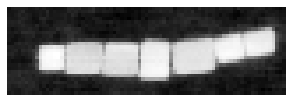


SI_FITO0_3 cubes.npy
Dimensions: (35, 69, 2048)


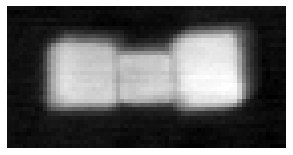


SI_FITO0_4 cubes.npy
Dimensions: (63, 63, 2048)


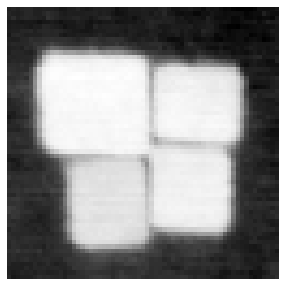


SI_FITO0_dimer.npy
Dimensions: (45, 78, 2048)


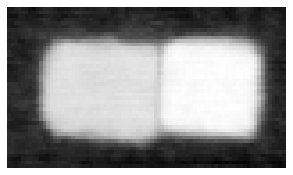


SI_FITO10_8particleisland.npy
Dimensions: (65, 56, 1920)


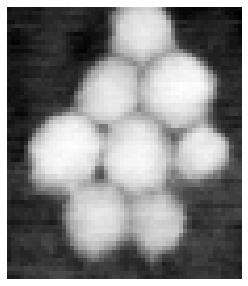


SI_FITO10_Antenna_1.npy
Dimensions: (35, 138, 2048)


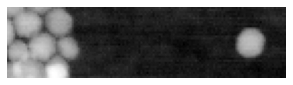


SI_FITO10_edgeisocube.npy
Dimensions: (48, 58, 2048)


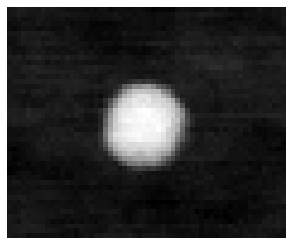


SI_FITO10_isolatedgroups_1.npy
Dimensions: (80, 80, 2048)


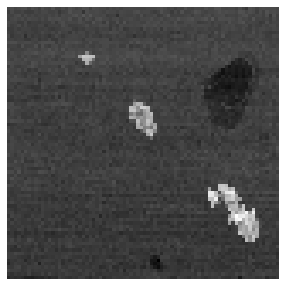


SI_FITO10_isolatedgroups_2.npy
Dimensions: (112, 75, 2048)


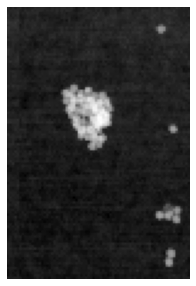


SI_FITO10_singleCUBE.npy
Dimensions: (63, 70, 2048)


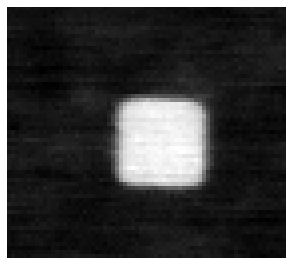


SI_FITO10_singlewideview.npy
Dimensions: (28, 112, 2048)


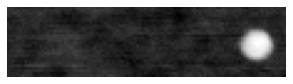


SI_FITO_0_2x1.npy
Dimensions: (39, 75, 2048)


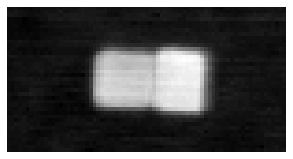


SI_FITO_0_group1.npy
Dimensions: (55, 70, 2048)


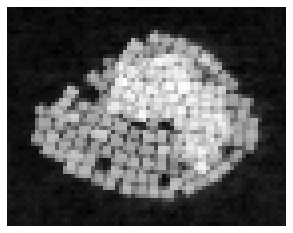

In [ ]:
filelist_ = glob.glob('*.npy')
metadatalist_ = glob.glob('*.json')

filelist = sorted(filelist_)
metadatalist = sorted(metadatalist_)

for ii in range(len(filelist)):
  plt.figure(figsize = (5,5))
  im = np.load(filelist[ii])
  print("\n" + filelist[ii]+ "\nDimensions: {}".format(im.shape))
  if np.ndim(im) == 2:  # these are all 3 dimensional so this should be ignored
      plt.imshow(im, origin='lower', cmap = 'gray')
  elif np.ndim(im) == 3:
      plt.imshow(np.mean(im[:,:,:],axis=2), origin='lower', cmap = 'gray_r')
      plt.axis('off')
  plt.show()

**<font color = 'crimson'>Organize the data</font>**:

Links dispersion to each dataset to get proper energy units, and primarily generates the spectrum image and energy parameters needed for further analysis
* `SI` is the 3-dim array, with axes: (X, Y, energy)
* `E` is the (calibrated) energy axis for SI
* `XY` is the product of X and Y axes (for flattening)
* `SIflat` is just the spatially flattened version of SI

In [ ]:
E_list = []
SI_list = []
XY_list = []
SIflat_list = []

for ii in range(len(filelist)):
  E, SI, XY, SIflat = organize_data(filelist[ii], plot = False)
  E_list.append(E), SI_list.append(SI), XY_list.append(XY), SIflat_list.append(SIflat)

<font color = 'crimson'>**Background subtraction</font> (removal of the ZLP)**

* This step can induce some controversy since there are many ways to approach the background subtraction, *especially* since we are in the low-loss regime of EELS where our signals of interest lie inherently close to the ZLP tail
* Since this notebook deals with a batch of several datasets which were all collected in similar circumstances (as well as the samples being similar in the sense of preparation, size, and properties), we employ the identical background subtraction method for all
  * We use a two region background fit:
    * Region 1: `0.075 eV to 0.08 eV`
    * Region 2: `0.17 eV to 0.2 eV`

In [ ]:
r1a, r1b, r2a, r2b = 0.075, 0.08, 0.17, 0.2

ENB_list = []
SINB_list = []
SINBflat_list = []

for ii in range(len(filelist)):
  ENB_, SINB_, SINBflat_ = bkgd_removal_all(r1a, r1b, r2a, r2b, E_list[ii], SI_list[ii], XY_list[ii])
  ENB_list.append(ENB_), SINB_list.append(SINB_), SINBflat_list.append(SINBflat_)

# Display `post-processed` data:

`Note in some datasets there is an` <font color = 'crimson'>artifact</font> `that can be seen`
* This appears as a "shadow" image of the same particle(s), but usually off to the upper left
* This is - from what we can tell - referred to as "Bumpium" or "Bumponium," and is a common issue that crops up due to interaction with the monochromater slit (false energy image in the wrong XY space) - I still don't really understand this. Note it is NOT related to diffraction as it occurs in amorphous materials identically.
* We see it in the images below because we incorporate the entire spectrum in the preview.
  * If we instead start at a little higher energy, we won't see this effect as much, since it is dominated in particular energy regions in the spectrum

* Also note the first strong peak seen in the background subtracted spectra is the $SiN_x$ phonon peak at 180 meV. It is present simply because the particles rest of the silicon nitride membrane, so it is present everywhere in these datasets. The $SiN_x$ could be considered part of the background but in this case we consider only the ZLP to be the background.
  * We would just fit and remove the silicon nitride as well, or even instead of the ZLP, but the shadow artifact doesn't play nicely with this. So instead, we just truncate the spectra


SI_FITO0_1Dchain_v1.npy


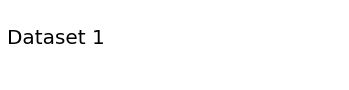

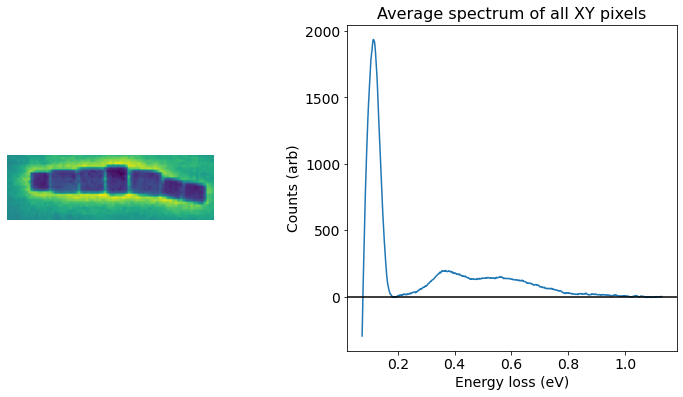


SI_FITO0_3 cubes.npy


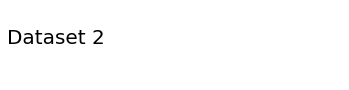

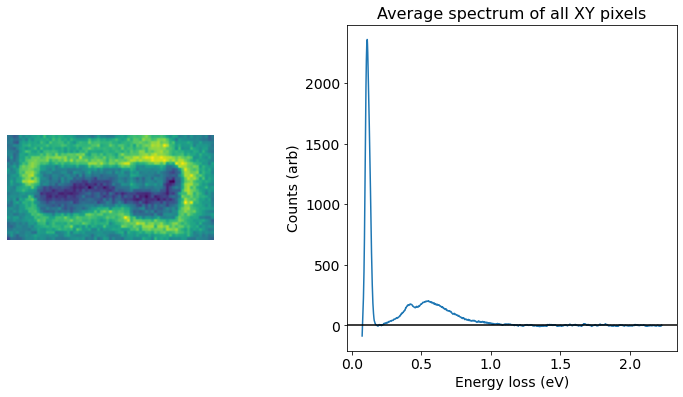


SI_FITO0_4 cubes.npy


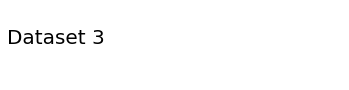

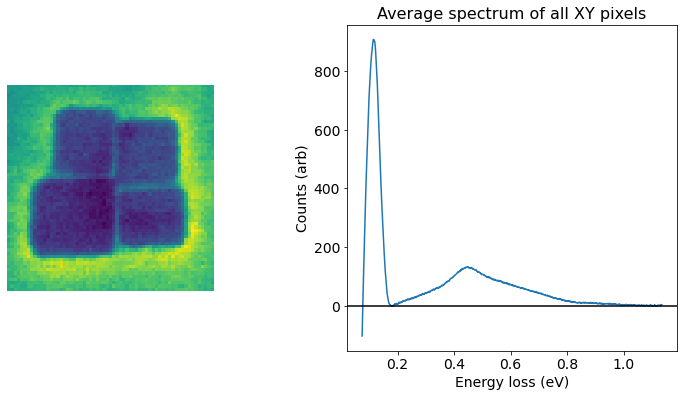


SI_FITO0_dimer.npy


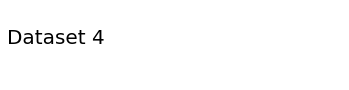

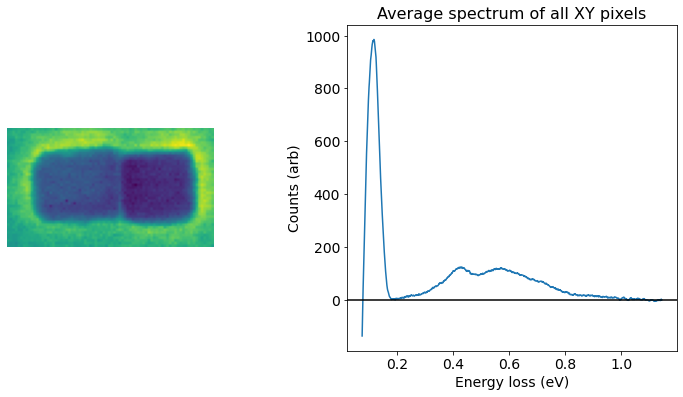


SI_FITO10_8particleisland.npy


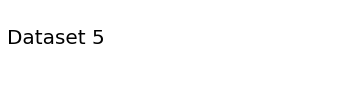

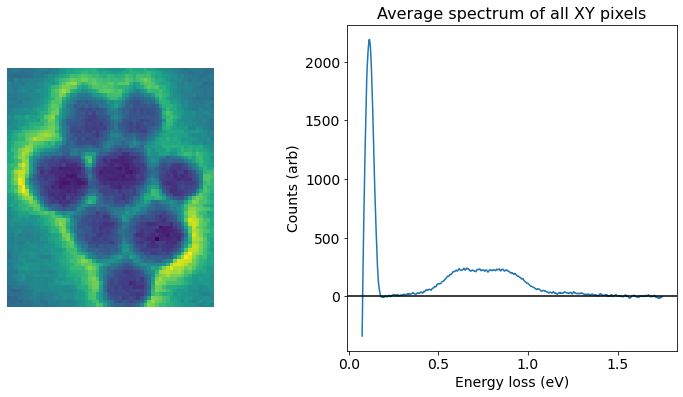


SI_FITO10_Antenna_1.npy


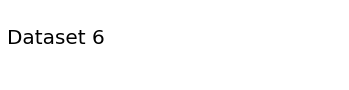

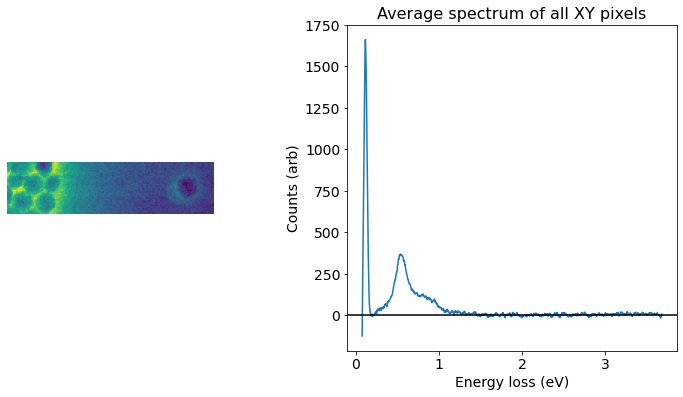


SI_FITO10_edgeisocube.npy


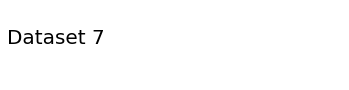

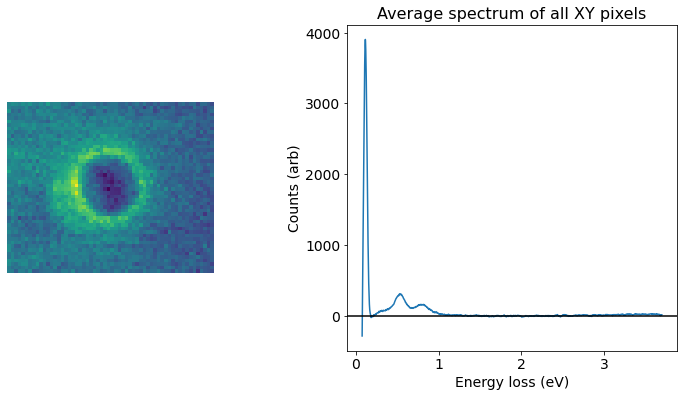


SI_FITO10_isolatedgroups_1.npy


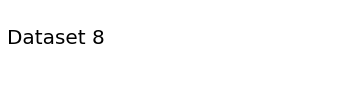

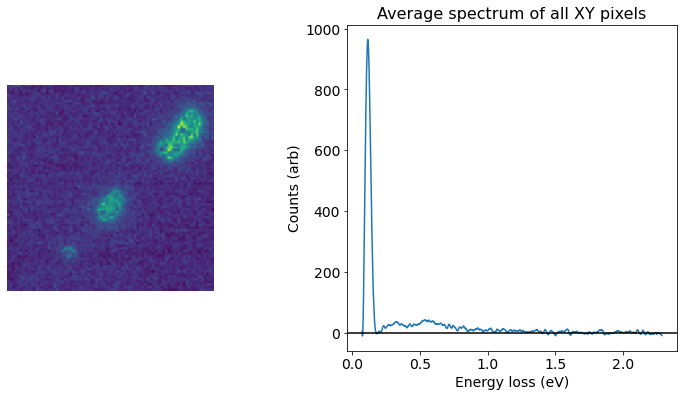


SI_FITO10_isolatedgroups_2.npy


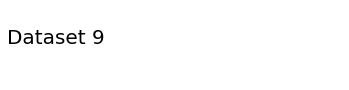

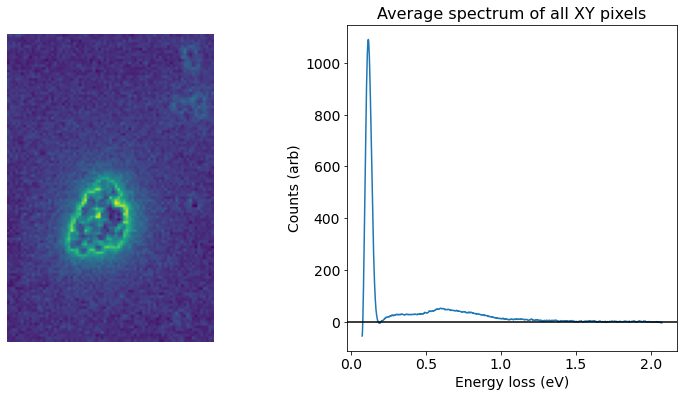


SI_FITO10_singleCUBE.npy


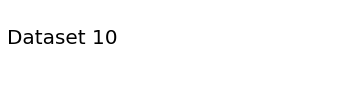

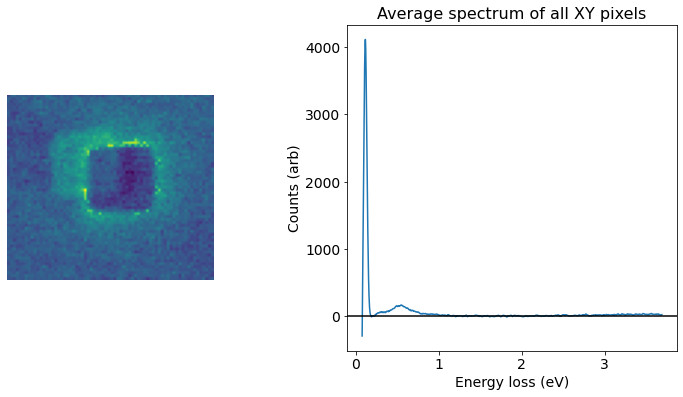


SI_FITO10_singlewideview.npy


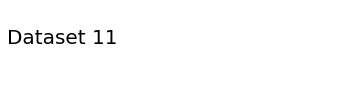

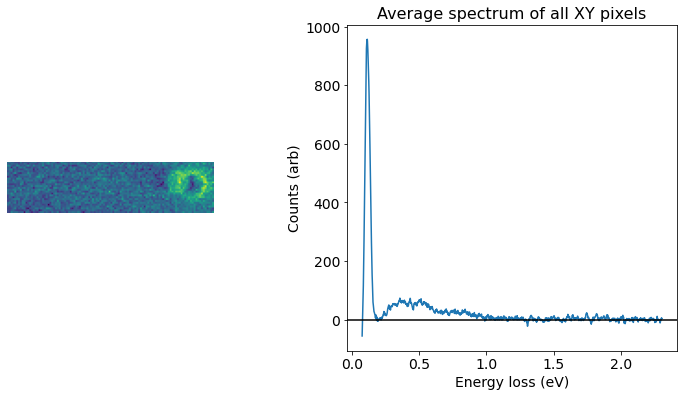


SI_FITO_0_2x1.npy


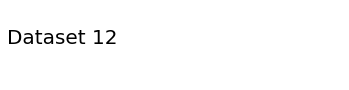

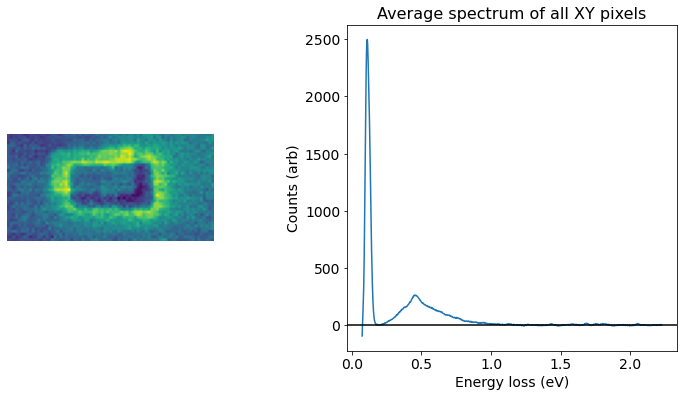


SI_FITO_0_group1.npy


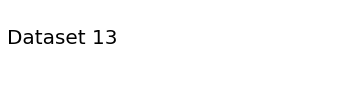

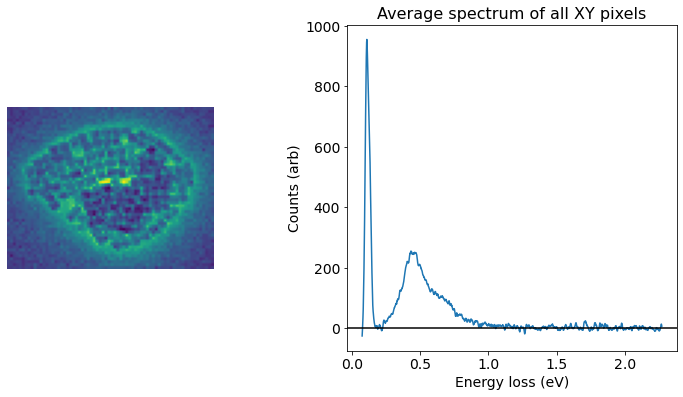

In [ ]:
for ii in range(len(filelist)):
  print("\n" + filelist[ii])
  plt.figure(figsize=(6,0.6))
  plt.title('\nDataset {}'.format(ii+1), fontsize = 20, loc = 'left')
  plt.axis('off')
  plt.figure(figsize = (12,6))
  gs = gridspec.GridSpec(1,2, width_ratios = (1,1.6), wspace = 0.5)
  ax1, ax2 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1])

  ax1.imshow(np.mean(SINB_list[ii], axis=2))

  ax2.plot(ENB_list[ii],np.mean(SINB_list[ii][:,:,:],axis=(0,1)))
  ax2.axhline(0, color = 'k')
  ax2.set_xlabel("Energy loss (eV)", fontsize = 14)
  ax2.set_ylabel("Counts (arb)", fontsize = 14)
  ax2.tick_params(labelsize = 14)
  ax2.set_title("Average spectrum of all XY pixels", fontsize = 16)
  
  # plt.setp([ax1], xticks=[], yticks=[])
  ax1.axis('off')
  plt.show()

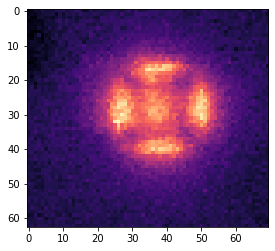

In [ ]:
ii = 9

E1, E2 = 0.65, 0.75      # select energy range (in eV) to display
i1, i2 = (np.abs(ENB_list[ii]-E1)).argmin(), (np.abs(ENB_list[ii]-E2)).argmin()

plt.figure()
plt.imshow(np.mean(SINB_list[ii][:,:,i1:i2],axis=2), cmap = 'magma')

In [ ]:
# Check properties of some datasets (unrelated)

filename = "SI_FITO10_Antenna_1.json"
testj = json.load(open(filename,'r'))
testj['datetime_modified']['local_datetime']

'2019-09-13T19:33:10.765865'

In [ ]:
!gdown https://drive.google.com/uc?id=19Bvq6Arf8EcpK7BAdzHf4rafdoL0j5Rs

Downloading...
From: https://drive.google.com/uc?id=19Bvq6Arf8EcpK7BAdzHf4rafdoL0j5Rs
To: /content/HAADF_FITO10_isocube1.npy
100% 17.8k/17.8k [00:00<00:00, 30.7MB/s]


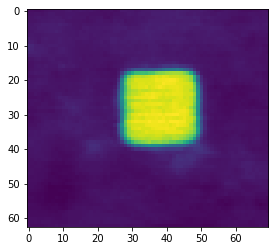

In [ ]:
testload = np.load("HAADF_FITO10_isocube1.npy")
plt.imshow(testload)

4. Do the standard NMF/PCA analysis for data exploration. Basically, at the end of this code block, the operator should have access to the PCA/NMF loadings and components for any of the files in (2) for arbitrary number of components for cleaned and corrected data. This is something you have done many times already, so up to this point it is largely cut and paste and adaptation.

* <font size = 4>In all datasets, remove silicon nitride (supporting membrane) phonon peak in all datasets by truncating below ```0.2 eV ``` </font>
   * we do not wish to include the strong peak of the support membrane in our results

Test scree plot (data set 0)

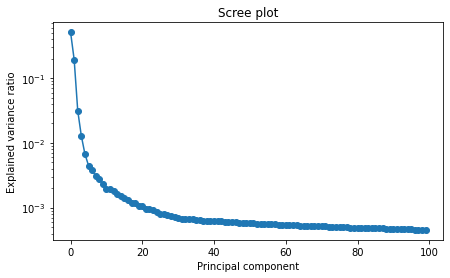

In [ ]:
ii = 0
truncate = truncate_spectrum(ENB_list[ii], cutoffenergy = 0.2)
SINBflat = SINBflat_list[ii]

fig, ax = plt.subplots(1,1,figsize=(7,4))

pca = PCA()
pca.fit(SINBflat[:,truncate:])
explained_var = pca.explained_variance_ratio_

ax.plot(explained_var[0:100], 'o-')
ax.semilogy()
ax.set_xlabel('Principal component')
ax.set_ylabel('Explained variance ratio');
ax.set_title('Scree plot');

* It turns out there are roughly the same number of components for each dataset, so we skip presenting PCA scree plots and choosing number of components based on this.

* *not strictly true when plasmon modes hybridize for example, but that is not the point of importance here*

* For simplicity, let us claim there are a total of <font size = 5, color = 'crimson'> **6** </font> components in all datasets hereafter

## PCA

      PCA deconvolution

In [ ]:
for ii in range(len(filelist)):
  Perform_PCA(SINB_list[ii], SINBflat_list[ii], ENB_list[ii], SI_list[ii])

## NMF

```NMF deconvolution```

* To handle  <font size = 4>**negativity**</font> , we use the convention of nulling any negatives, with the assumption that the noise levels are small enough for this to work
  * The function <font color = 'crimson'>```Perform_NMF_null()```</font> is used by default

* Note that in doing so, one component, usually the first, will be offset vertically as well. This may appear odd.

* Handling negativity can be done in a variety of methods; another common alternative is to **offset entire spectrum, at each pixel, by the most negative value (only if there is any negative value)**:

    * The function <font color = 'crimson'>```Perform_NMF_offset()```</font> may be used alternatively for this



* NMF calculations require a bit more time compared to PCA, but do tend to produce more physically sound results, which for the case of plasmons, are also more visually appealing

In [ ]:
for ii in range(len(filelist)):
  Perform_NMF_null(SINBflat_list[ii], ENB_list[ii], SI_list[ii], XY_list[ii], N = 6)

In [ ]:
for ii in range(len(filelist)):
  Perform_NMF_offset(SINBflat_list[ii], ENB_list[ii], SI_list[ii], XY_list[ii], N = 6)

# Particle mapping

5. And here the interesting part starts. We will want to explore how the plasmon EELS spectrum at a given location depends on particle configuration around it. There are several mehtods we can use to do it, but first things first. And the first thing is to localize the particles. There can be many strategies to do it, but let's start with manual labeling and refinement. 

5.a. Make a widget that shows you the image, and asks you to map the corners for particles. So you manually mark corners to particle 1, particle 2, and so on. Think about convenient workflow - when to stop, how to do error correciton, etc. But for few particles it is minimal effort. The widget should return the disctionary {'particle_1': [corner positions], 'particle_2': [corner positions], ...}

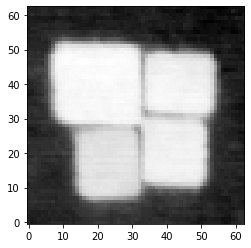

In [ ]:
# This is currently dataset #2:
ii = 2

# Let's use the ZLP map for "structure" since it is closest to a structural map:

ZLP = np.mean(SI_list[ii][:,:,:],axis = 2)
# set origin to lower so selecting coordinates is more natural to XY coordinate system
plt.imshow(ZLP, cmap = 'gray_r', origin = 'lower')

# plt.grid(True, color = 'r')

<font size = 5> `OpenCV magics: FindContour method` </font>

This method proceeds in the following manner:

  1. Artificially upscales the image to allow easier contour mapping
  2. Separate particles completely by taking natural logarithm (smooths intensities), sobel filtering (edges), gaussian blurring, and generating binary mask
  3. Find closed contours with CV2
  4. Use contour approximation and filtering the contour areas to select contours of only particles (avoid small and large contours unrelated to particles)
  5. Additionally, find the minimum rectangle (rotated) that bounds the contour, and extract this plus the angle of rotation
  6. Calculate the moment of each contour --> particle 'center' 

* User may need to play with function parameters here to ensure all particles (no more, no fewer) are found
* This is especially true for images originally acquired with low pixel count relative to the particle size, and if particles close together (see "Chain" dataset later)

(array([[40. , 43.6],
        [39.6, 20.6],
        [21. , 42.2],
        [18.6, 24.4]]),
 [-1.6846843957901, -0.0, -1.3971810340881348, 3.012786865234375])

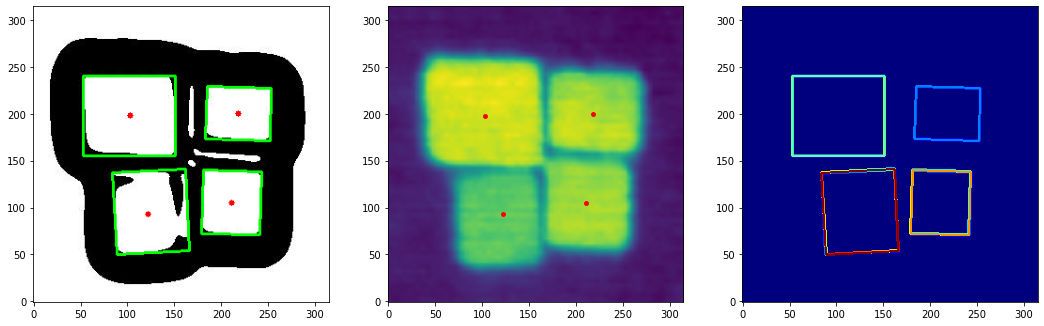

In [ ]:
scalefactor = 5
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 7, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.2);
Centers, Angles

* Here is the list which contains dictionaries for each particle
* Contains `rotation angle`, `center of particle`, and `rectangle stats`
* `rectangle stats` is in the form `[center_x, center_y],[width, height]`
  * note: particle corners need to be calculated geometrically from this, and are likely internal to the particles slightly due to using the filtering to draw contours


May 7 added `FilterImages` to `find_particles` function
* This is a list that contains a separate image for each particle, in which the entire image (same size as input image) is zeros, *except* for the contour surrounding the particle

In [ ]:
Particles = []
for ii in range(len(Centers)):
  Particle_temp = {"Rectstats": Rectstats[ii],"Center": Centers[ii], "Angle": Angles[ii]}
  Particles.append(Particle_temp)
Particles

[{'Angle': 1.6846843957901,
  'Center': array([40. , 43.6]),
  'Rectstats': array([[43.720224  , 40.08764038],
         [13.69995728, 11.28335571]])},
 {'Angle': 0.0,
  'Center': array([39.6, 20.6]),
  'Rectstats': array([[20.4, 39.5],
         [19.6, 17. ]])},
 {'Angle': 1.3971810340881348,
  'Center': array([21. , 42.2]),
  'Rectstats': array([[42.27235413, 21.16652679],
         [12.46458435, 13.47404022]])},
 {'Angle': -3.012786865234375,
  'Center': array([18.6, 24.4]),
  'Rectstats': array([[25.18287659, 19.22541199],
         [17.48107147, 15.52588196]])}]

Displayed in standard matplotlib format

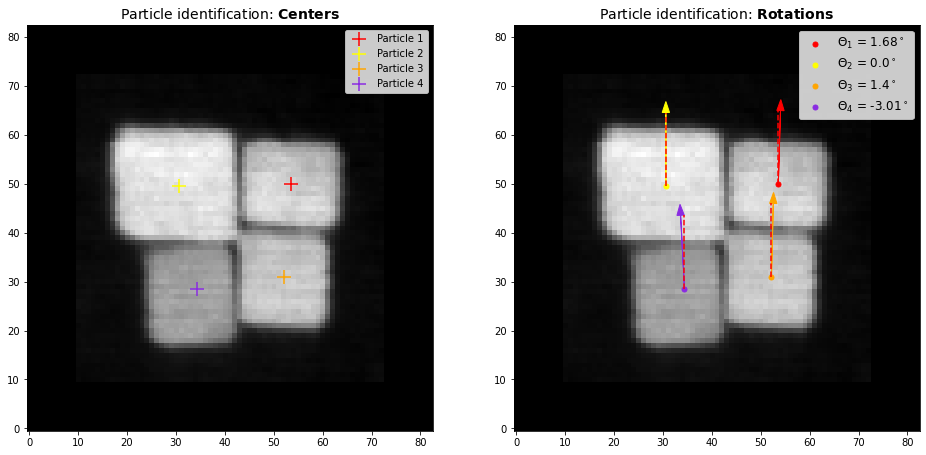

In [ ]:
ZLP_n = ((1/ZLP) - np.min(1/ZLP)) / np.ptp(1/ZLP)
arrowlen = 15
colors = ['r', 'yellow', 'orange', 'blueviolet', 'hotpink']
padsize = 10
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(np.pad(ZLP_n,padsize), cmap = 'gray', origin= 'lower')
for ii in range(len(Particles)):
  ax[0].scatter(Particles[ii]["Center"][1]+padsize, Particles[ii]["Center"][0]+padsize, c=colors[ii], s=200, marker = '+', label = 'Particle {}'.format(ii+1))
  # ax[0].scatter(Particles[ii]["Corners"][:,1]+padsize, Particles[ii]["Corners"][:,0]+padsize, c=colors[ii], s=30)
ax[0].set_title(r"Particle identification: $\bfCenters$", fontsize = 14)
ax[0].legend()

ax[1].imshow(np.pad(ZLP_n, padsize), cmap='gray', origin='lower')
for ii in range(len(Particles)):
  center = Particles[ii]["Center"]
  ax[1].scatter(center[1]+padsize, center[0]+padsize, c=colors[ii], s=25,
            label = '$\Theta_{}$ = {}$^\circ$'.format(ii+1,np.round(Particles[ii]["Angle"],2)))
  dx = arrowlen*np.sin(-np.deg2rad(-Particles[ii]["Angle"]))
  dy = arrowlen*np.cos(-np.deg2rad(Particles[ii]["Angle"]))
  ax[1].arrow(center[1]+padsize, center[0]+padsize, dx, dy, 
            color = colors[ii], head_width=1.5)
  xpart, ypart = [center[1]+padsize, center[1]+padsize], [center[0]+padsize, center[0]+padsize+dy]
  ax[1].plot(xpart,ypart, c='r', ls='--')
# plt.title('Particle orientations', fontsize = 14)
ax[1].set_title(r"Particle identification: $\bfRotations$", fontsize = 14)
ax[1].legend(fontsize = 12);


* We don't actually need the corner coordinates, we just need an image with a rectangle bounding a particle (this is easier)
* `patches.Rectangle` CAN be used for rotating the rectangle, but its pivot point is the lower left coordinate of the rectangle! Therefore we must transform coordinates if we want to use matplotlib.
* However, matplotlib doesn't modify the image data, only the axes.
* We want to detect particle edges with some vector, so this is necessary
* This is why the FilteredImages was added to the particle finder, which uses openCV

* Can show each of the rectangular contours individually:

[]

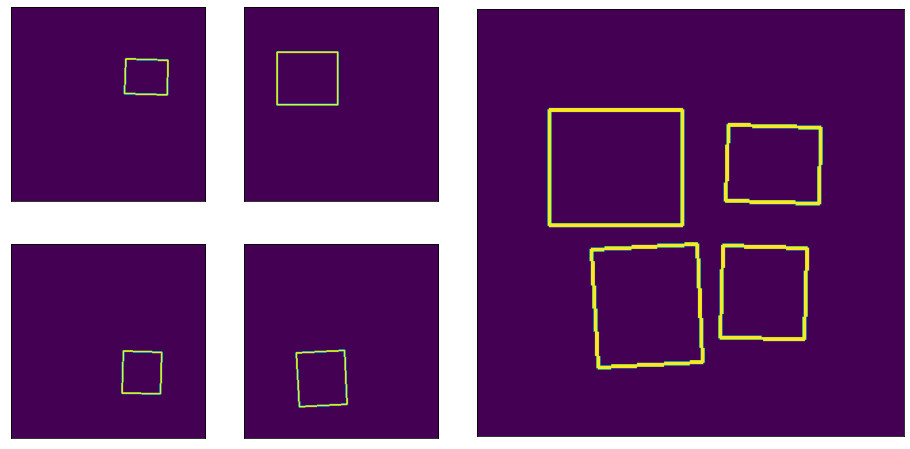

In [ ]:
plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,4)
ax00,ax01 = plt.subplot(gs[0,0]),plt.subplot(gs[0,1])
ax10,ax11 = plt.subplot(gs[1,0]),plt.subplot(gs[1,1])
ax2 = plt.subplot(gs[0:2,2:4])

FilterImagesAll = np.sum(FilterImages[:],axis=0)

ax00.imshow(FilterImages[0], origin = 'lower')
ax01.imshow(FilterImages[1], origin = 'lower')
ax10.imshow(FilterImages[2], origin = 'lower')
ax11.imshow(FilterImages[3], origin = 'lower')
ax2.imshow(FilterImagesAll, origin = 'lower')

plt.setp([ax00,ax01,ax10,ax11,ax2], xticks=[], yticks=[])

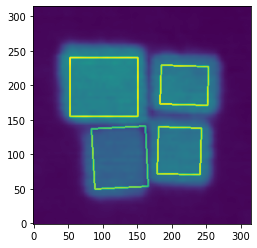

In [ ]:
ZLP_resize = resize(ZLP_n, (ZLP_n.shape[0]*scalefactor, ZLP_n.shape[1]*scalefactor))
ContourImage = np.copy(FilterImagesAll)

plt.figure()
plt.imshow(ZLP_resize + ContourImage, origin='lower')

# Edge angle sweeper
* Searches for edges by extending a line profile on an image from a specified point, and detecting the position when a threshold intensity is reached. Repeats this by revolving in a circle many line profiles
* Let's test this on a few different cases:

<font size = 5>`Contour image for single particle`</font>

Outside particle

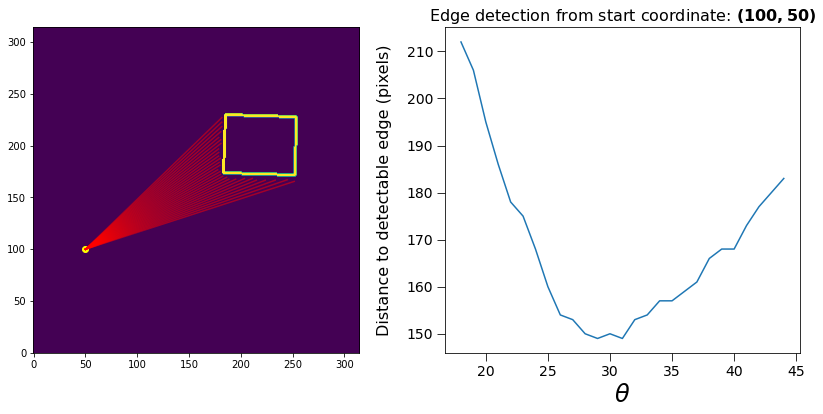

In [ ]:
startloc = (100,50)
Output = Edge_sweeper(FilterImages[0], 
                      startloc, 
                      sweepthresh = 0.1, 
                      stepsize = 1, 
                      order = 3, 
                      plot = True)

Inside particle

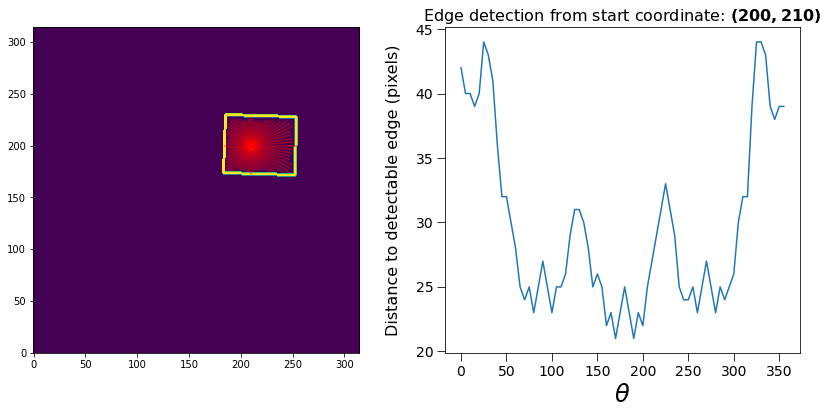

In [ ]:
startloc = (200,210)
Output = Edge_sweeper(FilterImages[0], 
                      startloc, 
                      sweepthresh = 0.1, 
                      stepsize = 1, 
                      order = 3, 
                      plot = True)

<font size = 5>`Contour image of all particles`</font>



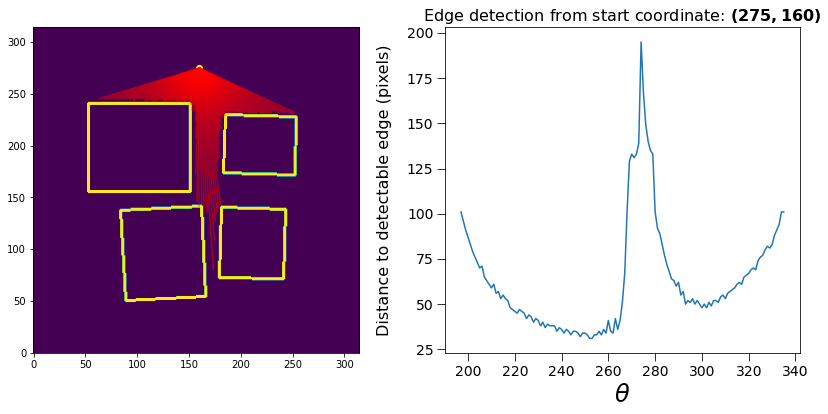

In [ ]:
contour_all = np.sum(FilterImages[:],axis=0)
startloc = (275,160)
Output = Edge_sweeper(contour_all, 
                      startloc, 
                      sweepthresh = 0.1, 
                      stepsize = 1, 
                      order = 3, 
                      plot = True)

<font size = 5>`ZLP/ADF image of the particles`</font>



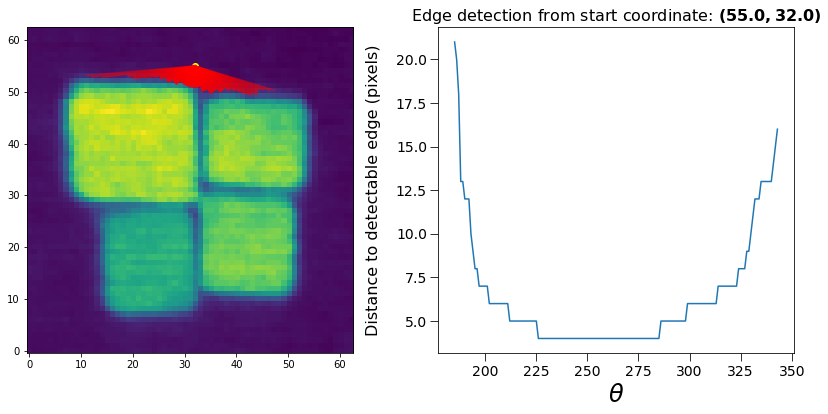

In [ ]:
startloc = (275/scalefactor,160/scalefactor)
Output = Edge_sweeper(ZLP_n, 
                      startloc, 
                      sweepthresh = 0.1, 
                      stepsize = 1, 
                      order = 3, 
                      plot = True)

And inside the particle, now where there is higher intensity:

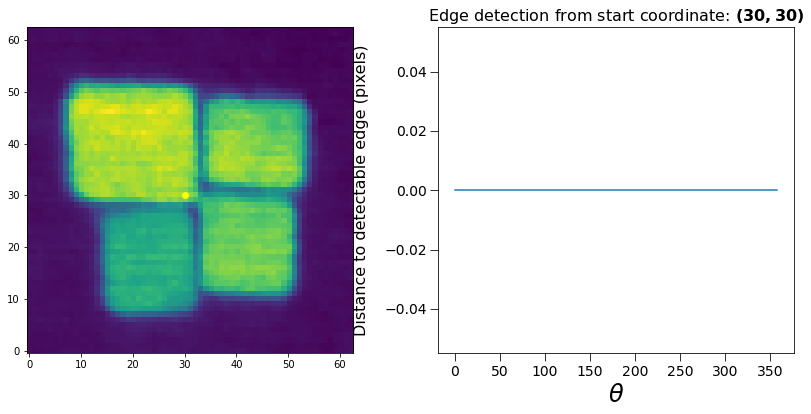

In [ ]:
startloc = (30,30)
Output = Edge_sweeper(ZLP_n, 
                      startloc, 
                      sweepthresh = 0.1, 
                      stepsize = 1, 
                      order = 3, 
                      plot = True)

Note that because intensity is already high at the start, the distance to the threshold intensity is basically zero. This is true because most of the image here is of particles, and most of the time we are INSIDE particles.

* I can make minor addition to allow for using this reliably INTERNAL to particles. But I was under the impression we are looking more for what is the spectral response and predictability of this EXTERNAL the particles. 

* Either way, please let me know I can do this no problem.

## Scratch work

0

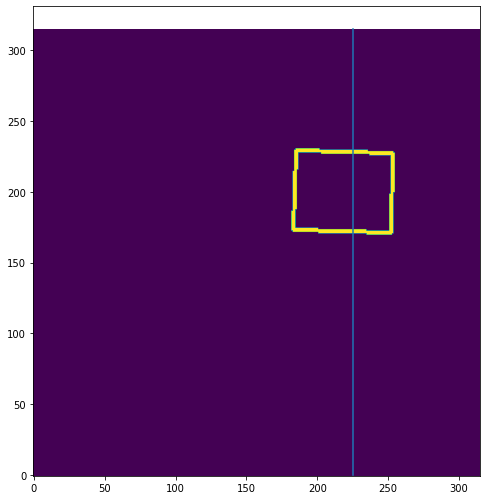

In [ ]:

z = FilterImages[0]

x0, y0 = 225, 0
x1, y1 = x0, FilterImages[0].shape[1]  # eventually will change based on angle probably. Or can just extend super far
num = 1000
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# Extract the values along the line, using cubic interpolation
zi = ndimage.map_coordinates(z, np.vstack((x,y)))

#-- Plot...
fig, ax = plt.subplots(1, figsize = (8,12))
ax.imshow(z, origin = 'lower')
ax.plot([x0, x1], [y0, y1])
# dx = x1-x0
# dy = y1-y0
# ax.arrow(x0, y0, dx, dy, color = 'r', head_width=200)
# ax.axis('image')

# axes[1].plot(zi)
np.min(np.where(zi<8))

In [ ]:
z.shape

(315, 315)

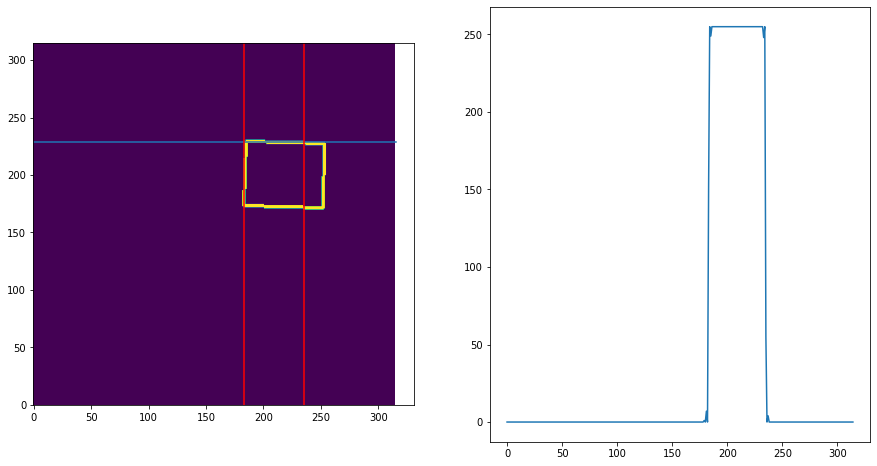

In [ ]:
z = FilterImages[0]

x0, y0 = 229, 0
x1, y1 = x0, FilterImages[0].shape[1]  # eventually will change based on angle probably. Or can just extend super far
num = z.shape[0] # MUST BE SQUARE IMAGE
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# Extract the values along the line, using cubic interpolation
zi = ndimage.map_coordinates(z, np.vstack((x,y)))

fig, ax = plt.subplots(1,2, figsize = (15,8))
ax[0].imshow(z, origin = 'lower')
ax[0].plot([y0, y1], [x0, x1])

ax[1].plot(zi)
testline1 = np.where(zi>10)[0][0]
testline2 = np.where(zi>10)[0][-1]

# rot = rotate_point([x0,y0], [x1,y1], sweeprange[ii])

ax[0].axvline(testline1, c='r')
ax[0].axvline(testline2, c='r')

In [ ]:
start = (229, 0)
end = (start[0], FilterImages[0].shape[1]*2)

Oh there's a built-in function in sci-kit image!

In [ ]:
from skimage.measure import profile_line

In [ ]:
testline = profile_line(z, start, end)

In [ ]:
print(start)
print(end)

(229, 0)
(229, 630)


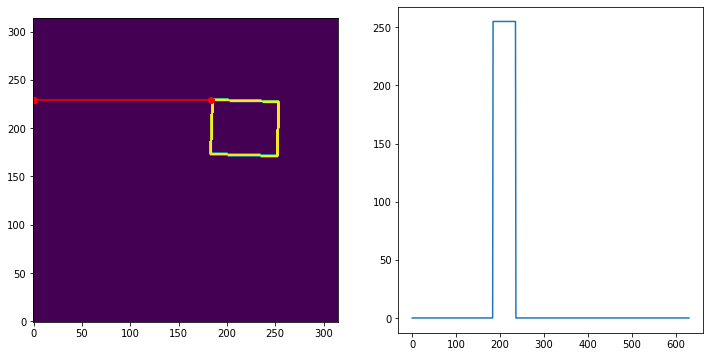

In [ ]:
start = (229, 0)
end = (start[0], FilterImages[0].shape[1]*2)
testline = profile_line(z, start, end)


fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(z, origin = 'lower')
ax[0].scatter(start[1],start[0], c='r')
ax[1].plot(testline)

first = np.min(np.where(testline>sweepthresh)) # only need the FIRST
# last = np.max(np.where(testline>sweepthresh))

ax[0].scatter(first,start[0], c='r')
ax[0].plot([start[1],first],[start[0],start[0]], c='r')

In [ ]:
end2

(544.0, 545.5960043841964)

edge detected at 184


190.4908171954553

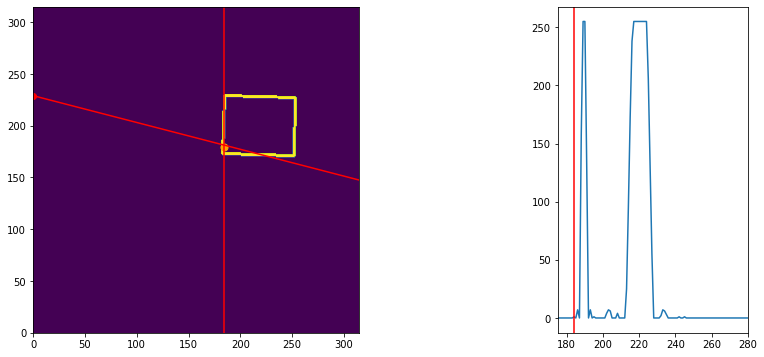

In [ ]:
# ROTATED point:
angle = -15
sweepthresh = 0.001
start = (229, 0)
end2 = rotate_point(start, end, angle)
testline = profile_line(z, start, end2, order = 3, linewidth = 1, cval = 0)

plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1,2, width_ratios = [3,1])
ax0,ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])

ax0.imshow(z, origin = 'lower')
ax0.scatter(start[1],start[0], c='r')
ax1.plot(testline)

try:
  first = np.min(np.where(testline>sweepthresh)) # only need the FIRST
  # print('edge detected at {}'.format(first))
  edgepoint_y = start[0] + np.abs((first - start[1])) * np.tan(np.deg2rad(angle))
  edgepoint = [first, edgepoint_y]
  edgedistance = compute_corner_dist(edgepoint, np.roll(start,1))
except ValueError:  # it means it never encountered a boundary
  first = end2[1]
  # print('no edge detected')
  edgepoint_y = np.nan
  edgepoint = [np.nan, np.nan]
  edgedistance = compute_corner_dist(edgepoint, start)

# last = np.max(np.where(testline>sweepthresh))

# calculate the point along the line where "first" occurs:
# angle is known already:



ax0.scatter(first, edgepoint_y, c='orange', s=50)

ax0.plot([start[1],end[1]],[start[0],end2[0]], c='r')

ax0.set_xlim(0,z.shape[0])
ax0.set_ylim(0,z.shape[1]);
ax1.set_xlim(175,280)

ax1.axvline(first, c='r')
ax0.axvline(first, c='r')
edgedistance


In [ ]:
sweeprange[0]

0

In [ ]:
Edge_sweeper()

In [ ]:
# # Inputs
# def Edge_sweeper(image, startcoord, sweepthresh = 0.1, stepsize = 1, order = 3):
#   '''
#   From a starting coordinate in an image, extends a vector (line profile) 
#   to the edge of the image and sweeps a full revolution around the image 
#   in increments given by stepsize. The first edge encountered by this vector 
#   is stored as a function of angle of rotation from the startcoord.
  
#   Parameters
#   ----------
#   image :  
#       Input 2D numpy array, image format. For use with CONTOUR images 
#       (simple thresholded image which are 0's everywhere except for particle
#       contours which are 1's)
#   startcoord : Tuple. E.g., (45,33)
#       Position from which to extend all vectors that sweep a circle
#   sweepthresh : Default 0.1
#       Threshold value which when reached calls for a positive edge detection
#   stepsize : default 1
#       Number of line profiles that are evenly spaced (in angular increments)
#       Set stepsize = 1 for 360 line profiles in a complete revolution
#   order : default 3
#       Order of spline interpolation (0 to 5 accepted) for lineprofiling 
#       across pixels. Order = 0 means nearest-neighbor interpolation. 

  
#   Returns
#   -------
#   EDT : "edge theta distance"
#       Array containing [theta, distance to edge at theta from startcoord]

#   '''
#   # image = FilterImages[0]
#   # startcoord = (229,0)
#   sweepthresh = 0.1
#   stepsize = 5

#   sweeprange = np.arange(0, 359, stepsize)
#   EDT = np.zeros((len(sweeprange), 2))
#   z = image  # MUST BE SQUARE IMAGE! if not, MAKE square! I can add function to do this if needed.. (take largest axis and pad other to make same size)
#   x0, y0 = startcoord
#   x1, y1 = x0, image.shape[1]*2
#   end = (startcoord[0], FilterImages[0].shape[1]*2)


#   # iterate over rotated vectors
#   # for ii in range(1):
#   for ii in range(len(sweeprange)):
#     angle = sweeprange[ii]
#     start = startcoord
#     end_rot = rotate_point(start, end, angle)
#     linescan = profile_line(z, start, end_rot, order = 3, linewidth = 1, cval = 0)

#     try:
#       first = np.min(np.where(linescan>sweepthresh)) # only need the FIRST
#       # print('edge detected at {}'.format(first))
#       edgepoint_y = start[0] + np.abs((first - start[1])) * np.tan(np.deg2rad(angle))
#       edgepoint = [first, edgepoint_y]
#       edgedistance = compute_corner_dist(edgepoint, np.roll(start,1))
#     except ValueError:  # it means it never encountered a boundary
#       first = end_rot[1]
#       # print('no edge detected')
#       edgepoint_y = np.nan
#       edgepoint = [np.nan, np.nan]
#       edgedistance = compute_corner_dist(edgepoint, start)

#     EDT[ii][0] = sweeprange[ii]
#     EDT[ii][1] = edgedistance

#   return output

(13.000000000000009, 13, (215, 221.5))

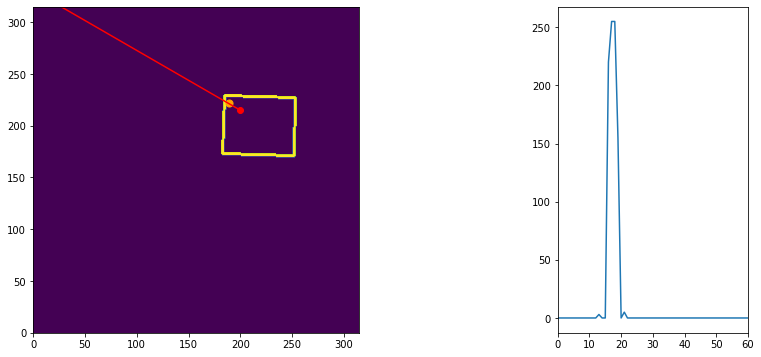

In [ ]:
image = FilterImages[0]
startcoord = (215,200)
sweepthresh = 0.1
stepsize = 5

sweeprange = np.arange(0, 359, stepsize)
EDT = np.zeros((len(sweeprange), 2))
z = image  # MUST BE SQUARE IMAGE! if not, MAKE square! I can add function to do this if needed.. (take largest axis and pad other to make same size)
x0, y0 = startcoord
x1, y1 = x0, image.shape[1]*2
end = (startcoord[0], FilterImages[0].shape[1]*2)

# iterate over rotated vectors
# for ii in range(1):

ii = 30

angle = sweeprange[ii]
start = startcoord
end_rot = rotate_point(start, end, angle)
linescan = profile_line(z, start, end_rot, order = 3, linewidth = 1, cval = 0)

try:
  first  = np.min(np.where(linescan>sweepthresh)) # + start[1] # only need the FIRST
  # print('edge detected at {}'.format(first))
  edgepoint_y = start[0] + first*np.sin(np.deg2rad(angle))
  edgepoint_x = start[1] + first*np.cos(np.deg2rad(angle))
  edgepoint = [edgepoint_x, edgepoint_y]
  edgedistance = compute_corner_dist(edgepoint, np.roll(start,1))
except ValueError:  # it means it never encountered a boundary
  first = end_rot[1]
  # print('no edge detected')
  edgepoint_y, edgepoint_x = np.nan, np.nan

  edgepoint = [np.nan, np.nan]
  edgedistance = compute_corner_dist(edgepoint, start)

EDT[ii][0] = sweeprange[ii]
EDT[ii][1] = edgedistance

plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1,2, width_ratios = [3,1])
ax0,ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])

ax0.imshow(z, origin = 'lower')
ax0.scatter(start[1],start[0], c='r')
ax1.plot(linescan)
ax1.set_xlim(0,60)
ax0.scatter(edgepoint_x, edgepoint_y, c='orange', s=50)

ax0.plot([start[1],end_rot[1]],[start[0],end_rot[0]], c='r')

ax0.set_xlim(0,image.shape[0])
ax0.set_ylim(0,image.shape[1]);

edgedistance, first, (start[0],edgepoint_y)

In [ ]:
def Edge_sweeper(image, startcoord, sweepthresh = 0.1, stepsize = 1, order = 3, plot = True):
  '''
  From a starting coordinate in an image, extends a vector (line profile) 
  to the edge of the image and sweeps a full revolution around the image 
  in increments given by stepsize. The first edge encountered by this vector 
  is stored as a function of angle of rotation from the startcoord.
  
  Parameters
  ----------
  image :  
      Input 2D numpy array, image format. For use with CONTOUR images 
      (simple thresholded image which are 0's everywhere except for particle
      contours which are 1's)
  startcoord : Tuple. E.g., (45,33)
      Position from which to extend all vectors that sweep a circle
  sweepthresh : Default 0.1
      Threshold value which when reached calls for a positive edge detection
  stepsize : default 1
      Number of line profiles that are evenly spaced (in angular increments)
      Set stepsize = 1 for 360 line profiles in a complete revolution
  order : default 3
      Order of spline interpolation (0 to 5 accepted) for lineprofiling 
      across pixels. Order = 0 means nearest-neighbor interpolation. 
  plot : True or False
      Whether or not to plot output of angle edge sweep. Recommend to keep on.
  
  Returns
  -------
  EDT : "edge distance theta"
      Array containing [theta, distance to edge at theta from startcoord,
      x distance to edge, y distance to edge]

  '''
  image = image # MUST BE SQUARE IMAGE! if not, MAKE square! 
                # I can add function to do this if needed.. (take largest axis and pad other to make same size)
  sweepthresh = sweepthresh
  stepsize = stepsize
  sweeprange = np.arange(0, 359, stepsize)
  EDT = np.zeros((len(sweeprange), 4))  # Final output array
    
  x0, y0 = startcoord
  end = (startcoord[0], image.shape[1]*2)  # Multiply by 2 to ensure lineprofile extends to end of image
  
  # iterate over rotated vectors

  for ii in range(len(sweeprange)):
    angle = sweeprange[ii]
    start = startcoord
    end_rot = rotate_point(start, end, angle)
    linescan = profile_line(image, start, end_rot, order = order, linewidth = 1, cval = 0)

    try:
      first = np.min(np.where(linescan>sweepthresh)) # only need the FIRST
      # print('edge detected at {}'.format(first))
      edgepoint_y = start[0] + first*np.sin(np.deg2rad(angle))
      edgepoint_x = start[1] + first*np.cos(np.deg2rad(angle))
      edgepoint = [edgepoint_x, edgepoint_y]
      edgedistance = compute_corner_dist(edgepoint, np.roll(start,1))
    except ValueError:  # it means it never encountered a boundary
      first = end_rot[1]
      # print('no edge detected')
      edgepoint_y, edgepoint_x = np.nan, np.nan
      edgepoint = [np.nan, np.nan]
      edgedistance = compute_corner_dist(edgepoint, start)

    if np.isnan(edgepoint_y):
      EDT[ii][0] = np.nan
    else:
      EDT[ii][0] = angle
    EDT[ii][1] = edgedistance
    EDT[ii][2] = edgepoint_x
    EDT[ii][3] = edgepoint_y
                  
  if plot == True:

    plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(1,2)
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.imshow(image, origin='lower')
    for ii in range(len(sweeprange)):
      ax1.plot([startloc[1], EDT[ii,2]], [startloc[0], EDT[ii,3]], c='r', alpha = 0.5)
    ax1.scatter(startloc[1], startloc[0], c='yellow')
    ax2.plot(EDT[:,0], EDT[:,1])
    ax2.set_xlabel(r'$\theta$', fontsize = 24)
    ax2.set_ylabel('Distance to detectable edge (pixels)', fontsize = 16, labelpad = 15)
    ax2.tick_params(labelsize = 14, size = 8)
    ax2.set_title('Edge detection from start coordinate: ' + r'$\bf({},{})$'.format(x0,y0), fontsize = 16);
    
  return EDT

In [ ]:
end_rot # end_rot seems ok. but the plotting is not

(430.0, -172.39092362730867)

In [ ]:
len(sweeprange)

72

In [ ]:
startcoor

In [ ]:
# startcoord = (200,200)
# x0, y0 = (200,200)
# (startcoord[0], image.shape[1]*2)

In [ ]:
scalefactor

5

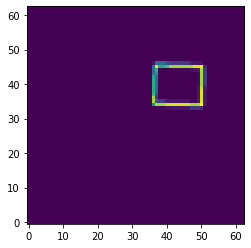

In [ ]:
testimg = resize(FilterImages[0], (FilterImages[0].shape[0]/scalefactor, FilterImages[0].shape[1]/scalefactor))
plt.imshow(testimg, origin = 'lower')

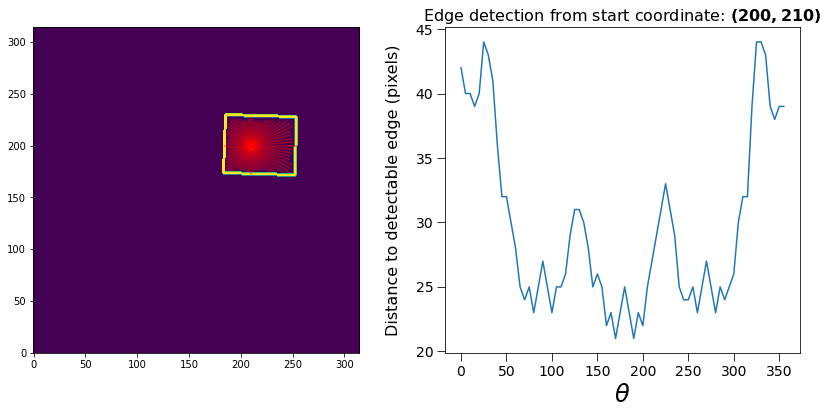

In [ ]:
startloc = (200,210)
testout = Edge_sweeper(FilterImages[0], startloc, stepsize = 5)

In [ ]:
anglemin, anglemax = np.nanmin(testout[:,0]), np.nanmax(testout[:,0])
anglemin, anglemax

(11.0, 83.0)

In [ ]:
## From startlocation, ONLY for anglemin:anglemax range (testout[:,0]'s), plot line to the detected edge 
# (the total LENGTHwhich is testout[:,1]), so delta x and delta y need to be calculated. But it was done in the function already.

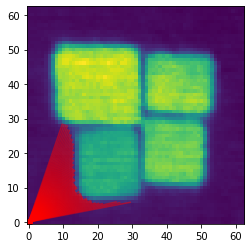

In [ ]:
plt.figure()
plt.imshow(ZLP_n, origin = 'lower')
plt.scatter(startloc[1], startloc[0], c='r')
for ii in range(len(sweeprange)):
  plt.plot([startloc[1], testout[ii,2]], [startloc[0], testout[ii,3]], c='r', alpha = 0.5)

# ax0.plot([start[1],end_rot[1]],[start[0],end_rot[0]], c='r')

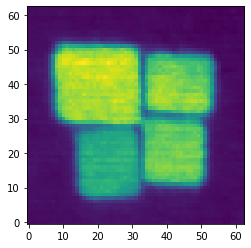

In [ ]:
plt.figure()
plt.imshow(ZLP_n, origin = 'lower')

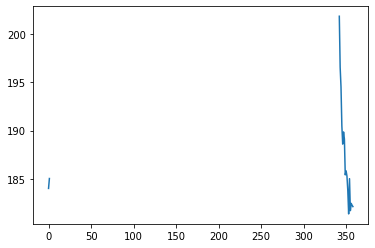

In [ ]:
plt.figure()
plt.plot(output[:,0], output[:,1])

In [ ]:
np.tan(np.deg2rad(angle))

0.0

In [ ]:
def rotate_point(origin, point, angle):
  ox, oy = origin
  point = point
  x, y = point
  qx = ox + np.cos(np.deg2rad(angle)) * (x - ox) + np.sin(np.deg2rad(angle)) * (y - oy)
  qy = oy + -np.sin(np.deg2rad(angle)) * (x - ox) + np.cos(np.deg2rad(angle)) * (y - oy)
  rotated = qx,qy
  return rotated

([225, 315], (540.0, 1.9288187086570814e-14))

In [ ]:
np.min(np.where(zi>0.1))/scalefactor # coordinate in real image coordinates. PERFECT. Just sweep this now across angles and DONE

71.8

In [ ]:
stepsize = 60
test = np.arange(0, 359, stepsize)

print(test.shape)
print(test[1])
test.shape

(6,)
60


(6,)

In [ ]:
# inputs
z = FilterImages[0]  # MUST BE SQUARE IMAGE! if not, MAKE square! I can add function to do this if needed.. (take largest axis and pad other to make same size)

x0, y0 = 225, 0
x1, y1 = x0, FilterImages[0].shape[1]*2 # Multiply the max y by 2 to ensure if we START at the max y, 
                                        # then we extend by another max y so when we begin rotating, we still cover the whole image space
sweepthresh = 0.1
stepsize = 5
output = np.zeros((stepsize, 2))
sweeprange = np.arange(0, 359, stepsize) # Always sweep full circle in increments defined by stepsize
num = z.shape[0]

for ii in range(len(sweeprange)):
  rot = rotate_point([x0,y0], [x1,y1], sweeprange[ii])
  x, y = np.linspace(x0, rot[0], num), np.linspace(y0, rot[1], num)
# Extract the values along the line, using cubic interpolation
  zi = ndimage.map_coordinates(z, np.vstack((x,y)))
  try:
    edge = np.min(np.where(zi>sweepthresh))
  except ValueError:
    # print('error @ {}'.format(ii))
    output[ii,0] = sweeprange[ii]
    output[ii,1] = np.nan
  if edge == 0:
    output[ii,0] = sweeprange[ii]
    output[ii,1] = np.nan
  else:
    output[ii,0] = sweeprange[ii]
    output[ii,1] = edge

plt.figure(figsize = (8,6))
plt.scatter(output[:,0], output[:,1])
plt.xlabel(r'$\theta$', fontsize = 24)
plt.ylabel('Distance to detectable edge (pixels)', fontsize = 16, labelpad = 15)
plt.tick_params(labelsize = 14, size = 8)
plt.title('Edge detection from start coordinate: ' + r'$\bf({},{})$'.format(x0,y0), fontsize = 16);

IndexError: ignored

View a slice of this to see the line profile and where it strikes the boundary

In [ ]:
np.min(output[:,1]), np.max(output[:,1])

(284.0, 303.0)

Text(0.5, 1.0, 'Edge detection from start coordinate $\\bf(225,0)$')

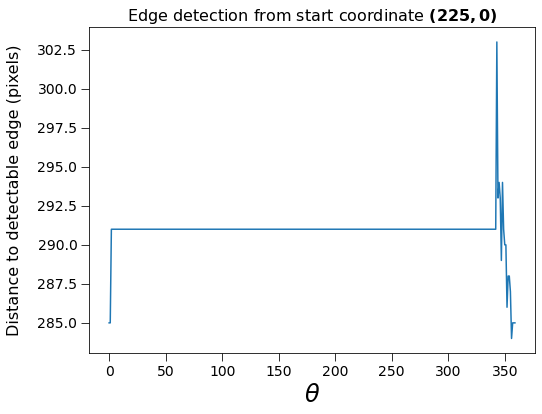

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(output[:,0], output[:,1])
plt.xlabel(r'$\theta$', fontsize = 24)
plt.ylabel('Distance to detectable edge (pixels)', fontsize = 16, labelpad = 15)
plt.tick_params(labelsize = 14, size = 8)
plt.title('Edge detection from start coordinate: ' + r'$\bf({},{})$'.format(x0,y0), fontsize = 16)

## Other scratch

In [ ]:
# Other

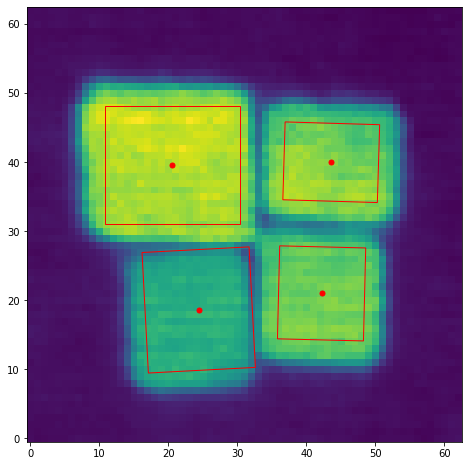

In [ ]:
f,(ax1) = plt.subplots(figsize=(8,8))
ax1.imshow(ZLP_n, origin = 'lower')

for ii in range(len(Centers)):

  # Grab rectangle parameters
  h, w, C, A = Rectstats[ii][1][0], Rectstats[ii][1][1], Centers[ii], Angles[ii]

  LL = [C[0] - w/2, C[1] - h/2]
  # Transform
  ts = ax1.transData
  tr = matplotlib.transforms.Affine2D().rotate_deg_around(C[1],C[0], A)
  t = tr + ts
  #Rotated rectangle patch
  rect1 = matplotlib.patches.Rectangle((LL[1],LL[0]),h,w,linewidth=1,edgecolor='r',facecolor='none',transform=t)
  ax1.add_patch(rect1)
  # Show centers
  ax1.plot(C[1], C[0], marker='o', markersize=5, color="r")

Create new image with only rectangles (contours around particles)
* Use this for determining distances from a specified point anywhere in the image space


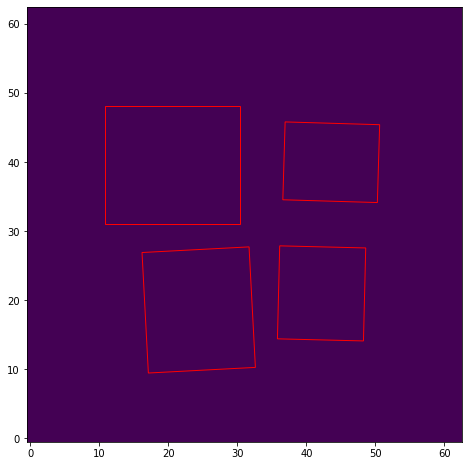

In [ ]:
f,(ax1) = plt.subplots(figsize=(8,8))
Zeros = np.zeros_like(ZLP_n)
ax1.imshow(Zeros, origin = 'lower')

for ii in range(len(Centers)):

  # Grab rectangle parameters
  h, w, C, A = Rectstats[ii][1][0], Rectstats[ii][1][1], Centers[ii], Angles[ii]

  LL = [C[0] - w/2, C[1] - h/2]
  # Transform
  ts = ax1.transData
  tr = matplotlib.transforms.Affine2D().rotate_deg_around(C[1],C[0], A)
  t = tr + ts
  #Rotated rectangle patch
  rect1 = matplotlib.patches.Rectangle((LL[1],LL[0]),h,w,linewidth=1,edgecolor='r',facecolor='none',transform=t)
  ax1.add_patch(rect1)
  # ax1.axis('off')

# cannot use the method below because it creates an image from array, not from another image
# im = Image.fromarray(ZLP255)
# im = im.convert("L")
# im.save("ZLP.jpeg")

# testimage = cv2.imread("ZLP.jpeg")

Unfortunately matplotlib cannot modify the image itself, so we must use cv2 or PIL or something else to do it. Luckily I have now directly added this to the function, so it generates this automatically!

(0.0, 1.0)

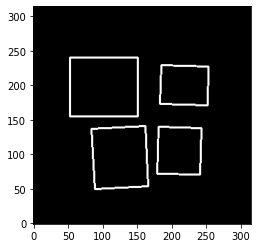

In [ ]:
plt.figure()
plt.imshow(f_image, origin='lower')
f_image.min(), f_image.max()


In [ ]:
plt.figure()
plt.imshow(f_image + ZLP_n)

ValueError: ignored

<Figure size 432x288 with 0 Axes>

# <font size = 6>```Four cubes```</font>

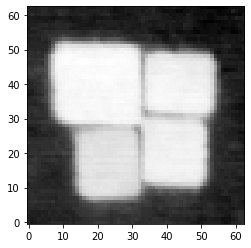

In [ ]:
# This is currently dataset #2:
ii = 2

# Let's use the ZLP map for "structure" since it is closest to a structural map:

ZLP = np.mean(SI_list[ii][:,:,:],axis = 2)
# set origin to lower so selecting coordinates is more natural to XY coordinate system
plt.imshow(ZLP, cmap = 'gray_r', origin = 'lower')

# plt.grid(True, color = 'r')

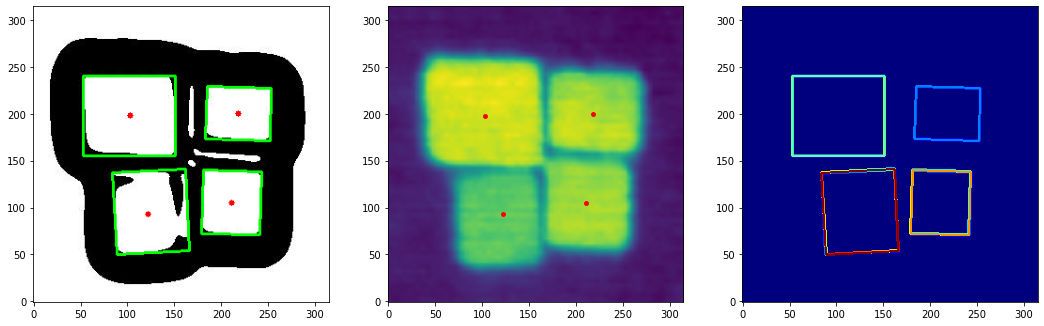

In [ ]:
scalefactor = 5
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 7, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.2);

# <font size = 6> `Single cube` </font>

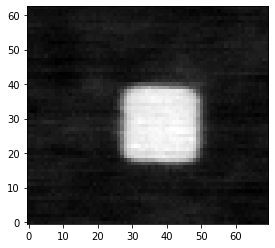

In [ ]:
# This is currently dataset #2:
ii = 9
ZLP = np.mean(SI_list[ii][:,:,:],axis = 2)
# set origin to lower so selecting coordinates is more natural to XY coordinate system
plt.imshow(ZLP, cmap = 'gray_r', origin = 'lower')

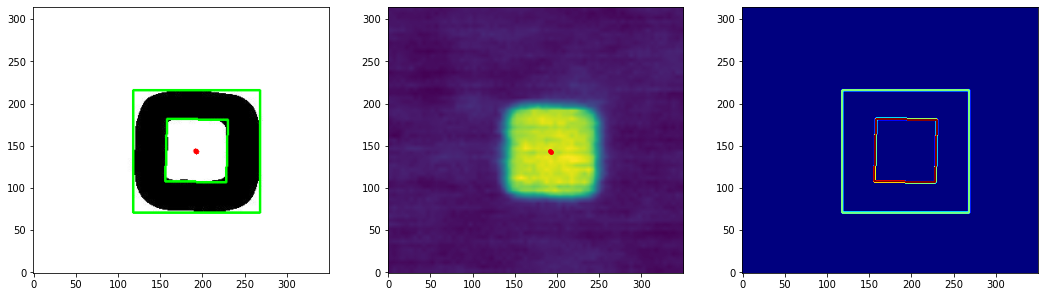

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP,
                                                          upscale = scalefactor, 
                                                          blur = 7, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01,
                                                          max_thresh = 0.2);

First hurdle, we have more contours than we wanted

* Reduce max_thresh here to avoid the outer contour:

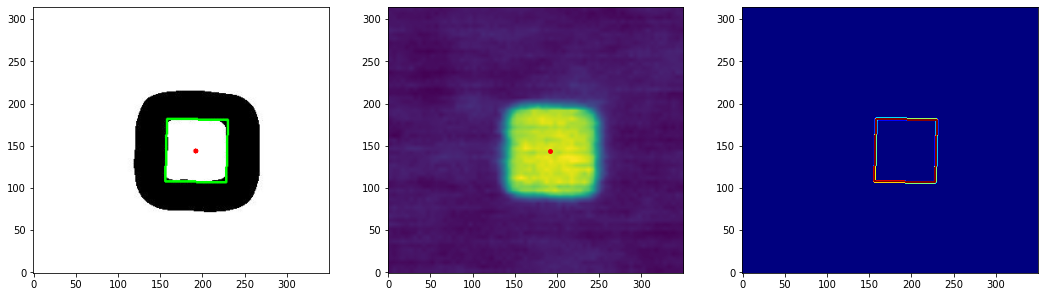

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 7, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.15);

Perform edge sweeper on the contours
* Keep in mind we are still using the upscaled images, so the startloc coordinates are in this upscaled coordinate system.

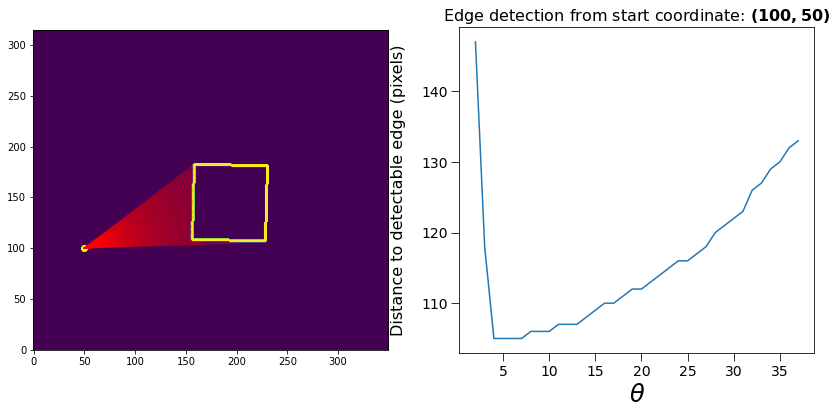

In [ ]:
startloc = (100,50)
Output = Edge_sweeper(FilterImages[0], 
                      startloc, 
                      sweepthresh = 0.1, 
                      stepsize = 1, 
                      order = 3, 
                      plot = True)

# <font size = 6> `Dimer #1 `</font>

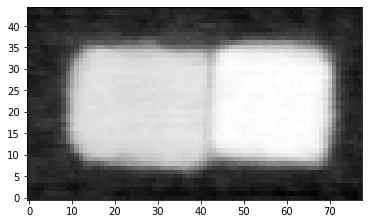

In [ ]:
# This is currently dataset #11:
ii = 3
ZLP = np.mean(SI_list[ii][:,:,:],axis = 2)
# set origin to lower so selecting coordinates is more natural to XY coordinate system
plt.imshow(ZLP, cmap = 'gray_r', origin = 'lower')

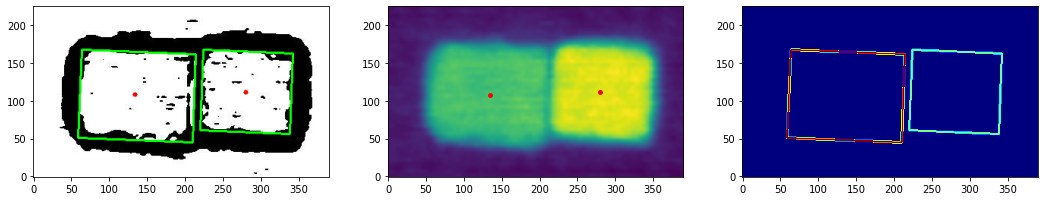

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 1, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.2);

# <font size = 6> `Dimer #2 `</font>

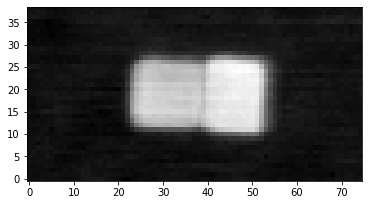

In [ ]:
# This is currently dataset #11:
ii = 11
ZLP = np.mean(SI_list[ii][:,:,:],axis = 2)
# set origin to lower so selecting coordinates is more natural to XY coordinate system
plt.imshow(ZLP, cmap = 'gray_r', origin = 'lower')

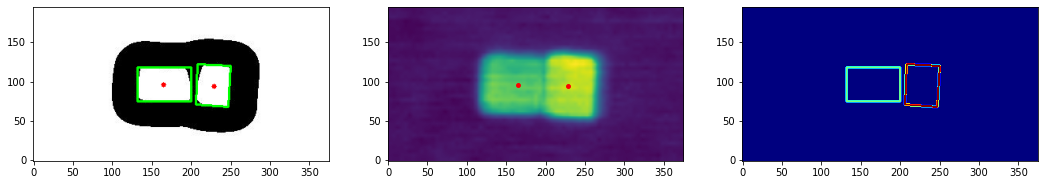

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 7, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.2);

Second hurdle, left particle contour looks too wide. Reduce `blur`

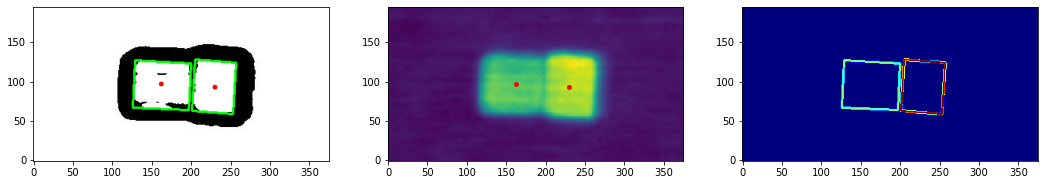

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 2, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.2);

# <font size = 6> `Trimer` </font>

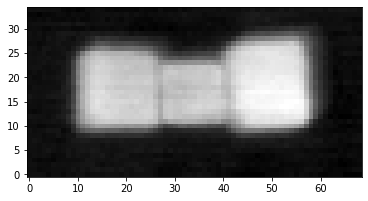

In [ ]:
# This is currently dataset #11:
ii = 1
ZLP = np.mean(SI_list[ii][:,:,:],axis = 2)
# set origin to lower so selecting coordinates is more natural to XY coordinate system
plt.imshow(ZLP, cmap = 'gray_r', origin = 'lower')

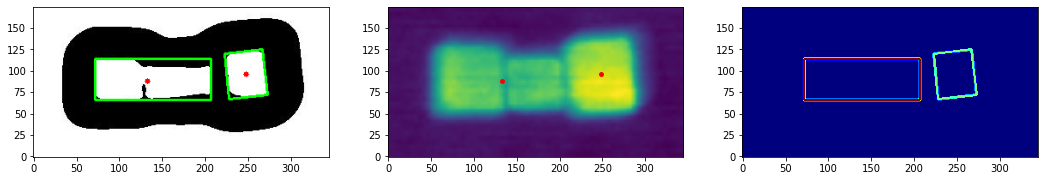

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 7, 
                                                          binarythresh = 0.15, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.2);

Too much blur again:
* Actually reduced binary threshold to 0.1, too

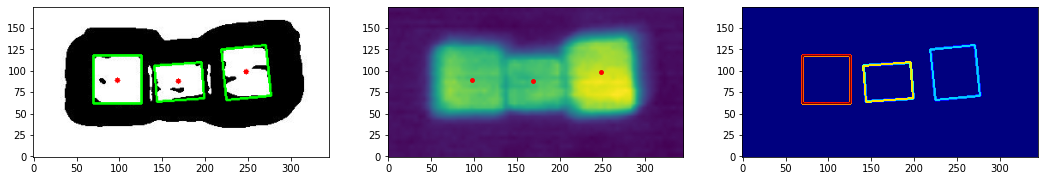

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = scalefactor, 
                                                          blur = 3, 
                                                          binarythresh = 0.1, 
                                                          min_thresh = 0.01, 
                                                          max_thresh = 0.2);

# <font size = 6> `Chain` </font>

This one is toughest, but with some tweaking of the parameters, it can be done

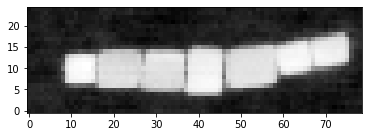

In [ ]:
# This is currently dataset #11:
ii = 0
ZLP = np.mean(SI_list[ii][:,:,:],axis = 2)
# set origin to lower so selecting coordinates is more natural to XY coordinate system
plt.imshow(ZLP, cmap = 'gray_r', origin = 'lower')

Tweaking this one a little more:
* Upscaled 10x instead of 5x
* NO blur, since particles pixelated and very close
* fine tweak of binary thresholding and the contour areas (min_thresh and max_thresh)
* but, it works, and rather well I think. It has fairly correct sizes and rotations of all cubes.

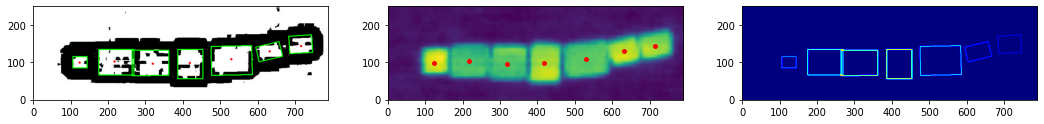

In [ ]:
Centers, Angles, Rectstats, FilterImages = find_particles(ZLP, 
                                                          upscale = 10, 
                                                          blur = 0, 
                                                          binarythresh = 0.07, 
                                                          min_thresh = 0.002, 
                                                          max_thresh = 0.05);

Testing the edge sweeper:

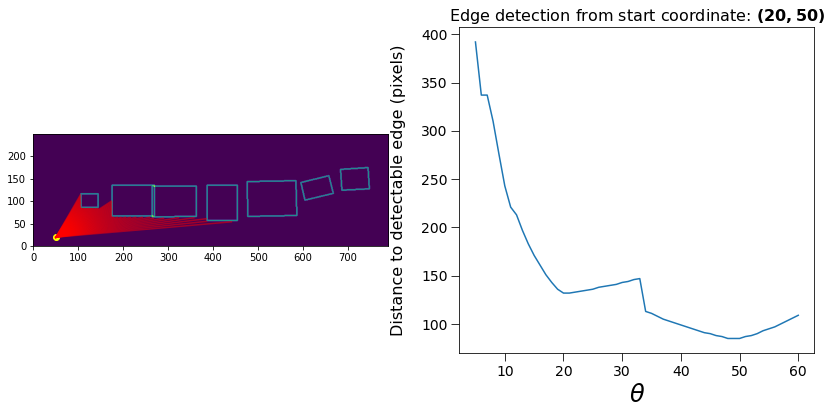

In [ ]:
startloc = (20,50)
EdgeImage = np.sum(FilterImages[:],axis=0) # Using all cubes at once (but note,  this does not give 
                                           # particle-specific distances unless we separate cube contours)

Output = Edge_sweeper(EdgeImage, 
                      startloc, 
                      sweepthresh = 0.1, 
                      stepsize = 1, 
                      order = 3, 
                      plot = True)

* As you can see, I gave up on the corner finding. It was giving inconsistent results and required a LOT more tuning and preconditioning of the data to give decent output, and even then it wasn't as good as the method I've adopted.

* There could be a further refinement step starting with this current output. I have tried doing further corner finding using the contours as cropped regions of the image, but still inconsistent.

* I will need to understand what you mean by maximizing overlap between square and particle from PCA map (if you think we need to further refine at all). It doesn't sound like much to do for refining though (?)

5.b. Make a refinement function. Use the corners as a first guess, define function that returns center position (x,y), rotation angle (theta) and size (a) for a given particle by maximizing overlap between square and particle (from PCA map) 

5.c. Run the refinement function on particle set, so now instead of the initial dictionary of manual labels you get the refined positions and areas. This will be our starting point for GP, DNN, and BNN analysis.

Onwards!

Beware of unlocking the secrets of the puzzle cube.